In [3]:
from google.colab import drive
drive.mount('/content/drive')

#Import Data

In [ ]:
# get data from kaggle
!pip install kaggle
!mkdir ~/.kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("talaviyabhavik/customer-support-training-data")

print("Path to dataset files:", path)

100%|██████████| 2.87M/2.87M [00:00<00:00, 120MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/talaviyabhavik/customer-support-training-data/versions/1


# General EDA

In [ ]:
# # get csv file for data
# import pandas as pd
# file_path = '/root/.cache/kagglehub/datasets/talaviyabhavik/customer-support-training-data/versions/1/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11 (1).csv'
# df = pd.read_csv(file_path)
# df.head()

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
dataset_name = "talaviyabhavik/customer-support-training-data"
path = kagglehub.dataset_download(dataset_name)

# Check if path is a directory and find the CSV file
if os.path.isdir(path):
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            file_path = os.path.join(path, filename)
            break  # Stop after finding the first CSV file
    else:
        raise FileNotFoundError(f"No CSV file found in the downloaded dataset: {dataset_name}")
else:
    file_path = path  # If path is directly to the CSV file

# Read CSV file
df = pd.read_csv(file_path)
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [ ]:
df = df.drop(['flags', 'response'], axis=1)

In [ ]:
df['intent'].unique()

array(['cancel_order', 'change_order', 'change_shipping_address',
       'check_cancellation_fee', 'check_invoice', 'check_payment_methods',
       'check_refund_policy', 'complaint', 'contact_customer_service',
       'contact_human_agent', 'create_account', 'delete_account',
       'delivery_options', 'delivery_period', 'edit_account',
       'get_invoice', 'get_refund', 'newsletter_subscription',
       'payment_issue', 'place_order', 'recover_password',
       'registration_problems', 'review', 'set_up_shipping_address',
       'switch_account', 'track_order', 'track_refund'], dtype=object)

In [ ]:
df['intent'].value_counts()

,count
intent,
contact_customer_service,1000
complaint,1000
check_invoice,1000
switch_account,1000
edit_account,1000
contact_human_agent,999
check_payment_methods,999
delivery_period,999
newsletter_subscription,999


In [ ]:
df['instruction'].value_counts()

,count
instruction,
shiping to {{Delivery City}},8
do you ship to {{Delivery City}}?,8
shipments to {{Delivery City}},8
deliveries to {{Delivery City}},8
is it possible to order from {{Delivery City}}?,8
...,...
help to speak with aj assistant,1
I want to contact a human agent,1
i do not understand ya is it possible to speak to osmebody,1


In [ ]:
df['instruction'].iloc[100]

'where can I cancel order {{Order Number}}?'

In [ ]:
df.rename(columns={'instruction': 'description'}, inplace=True)

In [ ]:
# Select the intentes you want to concatenate them with the main Category
categories_intents = {"ACCOUNT":['registration_problems' , 'recover_password'] , "FEEDBACK" : ["complaint","review"]}

def concatenate_intents(categories_intents,text) :
  for category,intent in categories_intents.items() :
    if text in intent :
        # print(text,intent,category)
        category = category.lower()
        text = category+"_"+text
        # print(intent)
    else :
      continue

  return text


df['new_intent'] = df['intent'].apply(lambda x : concatenate_intents(categories_intents,x))


In [ ]:
df.head()

,description,category,intent,new_intent
0,question about cancelling order {{Order Number}},ORDER,cancel_order,cancel_order
1,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,cancel_order
2,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,cancel_order
3,I need to cancel purchase {{Order Number}},ORDER,cancel_order,cancel_order
4,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,cancel_order


In [ ]:
df  = df[["new_intent",'description']]

In [ ]:
df.shape

(26872, 2)

In [ ]:
# Drop nulls and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

<ipython-input-18-a2dacc99e6a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-18-a2dacc99e6a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [ ]:
df.shape

(24635, 2)

#NLP Preprocessing

In [ ]:
df.head()

,new_intent,description
0,cancel_order,question about cancelling order {{Order Number}}
1,cancel_order,i have a question about cancelling oorder {{Or...
2,cancel_order,i need help cancelling puchase {{Order Number}}
3,cancel_order,I need to cancel purchase {{Order Number}}
4,cancel_order,"I cannot afford this order, cancel purchase {{..."


In [ ]:
for i in df['new_intent'].unique():
  print(i + ': ' + str(df[df['new_intent'] == i].shape[0]))
  print(df[df['new_intent'] == i]['description'].iloc[100])
  print()

cancel_order: 493
would it be possible to cancel purchase {{Order Number}}

change_order: 870
I made a mistake, I want help editing order {{Order Number}}

change_shipping_address: 973
I entered a wrong address, will you help me update it?

check_cancellation_fee: 950
I need help checking the early exit charge

check_invoice: 921
is it possible to look for my bill #85632

check_payment_methods: 999
want assistance listing your available payment options

check_refund_policy: 997
could I see in what situations can I request my money back?

feedback_complaint: 1000
how to make a complaint against your organization?

contact_customer_service: 1000
I want to speak with customer assistance

contact_human_agent: 999
help me to contact an operator

create_account: 892
can I open a freemium account?

delete_account: 918
problem with {{Account Type}} account terminations

delivery_options: 660
is it possible toorder from {{Delivery City}}

delivery_period: 999
need to check how soon can i expect

In [ ]:
!pip install contractions
# Download 'wordnet' dataset
# Install the textblob package
import nltk
nltk.download('wordnet')
nltk.download('punkt') # Download the 'punkt' resource for sentence tokenization
nltk.download('punkt_tab')
nltk.download('stopwords')
!pip install textblob

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 🔹 1. Advanced Text Preprocessing Function

import contractions
import regex as re
import string
import nltk # Import nltk
from nltk.tokenize import word_tokenize # Import word_tokenize
from nltk.corpus import stopwords # Import stopwords
from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer
from textblob import TextBlob # Import TextBlob
from sklearn.model_selection import train_test_split # Import train_test_split


def clean_text_advanced(text):
    # Expand contractions
    text = contractions.fix(text)

    # Lowercase
    text = text.lower()

    # Remove digits and punctuation
    text = re.sub(r'\{\{.*?\}\}', '', text)

    text = text.split()
    text = ' '.join(text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

     # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    essential_words = {'not', 'no', 'cannot'}
    custom_stop_words = stop_words - essential_words
    tokens = [word for word in tokens if word not in custom_stop_words]


    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token,pos='v') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='v') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='a') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='r') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='s') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='n') for token in tokens]

    # Join tokens back into a string
    cleaned_text = ' '.join(lemmatized_tokens)

    # Optional: Spell correction (can slow down processing)
    cleaned_text = str(TextBlob(cleaned_text).correct()) # Now TextBlob is defined

    # # Spell correction (optional - slow on large datasets)
    # text = str(TextBlob(text).correct())

    return cleaned_text
# Apply preprocessing
df['cleaned_description'] = df['description'].apply(clean_text_advanced)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_description'], df['new_intent'], test_size=0.2, random_state=42)

# Display the preprocessed dataset
print(df.head())

     new_intent                                        description  \
0  cancel_order   question about cancelling order {{Order Number}}   
1  cancel_order  i have a question about cancelling oorder {{Or...   
2  cancel_order    i need help cancelling puchase {{Order Number}}   
3  cancel_order         I need to cancel purchase {{Order Number}}   
4  cancel_order  I cannot afford this order, cancel purchase {{...   

                cleaned_description  
0         question concealing order  
1         question concealing order  
2     need help concealing purchase  
3              need cancel purchase  
4  not afford order cancel purchase  


In [ ]:
df.to_csv('/content/cleaned_data.csv', index=False)

In [ ]:
import os

# Create the directory
os.makedirs('/content/drive/My Drive/cleaned_data', exist_ok=True)

#save the DataFrame to CSV
df.to_csv('/content/drive/My Drive/cleaned_data/cleaned_customer_support_data.csv', index=False)

In [4]:
df = pd.read_csv('/content/drive/My Drive/cleaned_data/cleaned_customer_support_data.csv')

In [ ]:
for i in df['new_intent'].unique():
  print(i)
  print(df[df['new_intent'] == i]['cleaned_description'].iloc[100])
  print()

cancel_order
would possible cancel purchase

change_order
made mistake want help editing order

change_shipping_address
entered wrong address help update

check_cancellation_fee
need help checking early exit charge

check_invoice
possible look bill

check_payment_methods
want assistance listing available payment option

check_refund_policy
could see situation request money back

feedback_complaint
make complaint organization

contact_customer_service
want speak customer assistance

contact_human_agent
help contact operator

create_account
open premium account

delete_account
problem account termination

delivery_options
possible order

delivery_period
need check soon expect product

edit_account
dating account

get_invoice
assistance downloading voice

get_refund
relating

newsletter_subscription
subscribe corporate newsletter

payment_issue
issue payment

place_order
not know purchase several product

account_recover_password
help rest pas user account

account_registration_problems
n

# label encoder

In [ ]:
import pandas as pd
df = pd.read_csv('/content/cleaned_customer_support_data.csv')

In [ ]:
#Import train_test_split
from sklearn.model_selection import train_test_split

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_description'], df['new_intent'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print mapping of categories to numbers
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'account_recover_password': np.int64(0), 'account_registration_problems': np.int64(1), 'cancel_order': np.int64(2), 'change_order': np.int64(3), 'change_shipping_address': np.int64(4), 'check_cancellation_fee': np.int64(5), 'check_invoice': np.int64(6), 'check_payment_methods': np.int64(7), 'check_refund_policy': np.int64(8), 'contact_customer_service': np.int64(9), 'contact_human_agent': np.int64(10), 'create_account': np.int64(11), 'delete_account': np.int64(12), 'delivery_options': np.int64(13), 'delivery_period': np.int64(14), 'edit_account': np.int64(15), 'feedback_complaint': np.int64(16), 'feedback_review': np.int64(17), 'get_invoice': np.int64(18), 'get_refund': np.int64(19), 'newsletter_subscription': np.int64(20), 'payment_issue': np.int64(21), 'place_order': np.int64(22), 'set_up_shipping_address': np.int64(23), 'switch_account': np.int64(24), 'track_order': np.int64(25), 'track_refund': np.int64(26)}


# TF-IDF Vectorization
Feature Extraction using TF-IDF vectorization to transform the cleaned text into numerical features. The training (X_train_tfidf) and testing (X_test_tfidf)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(y_train.shape)
print(y_test.shape)
# print(X_train_tfidf)

(19708, 888)
(4927, 888)
(19708,)
(4927,)


# Model Training & Evaluation

## ML Models

### Traditional ML models first:

Logistic Regression

Support Vector Machine (SVM)

Random Forest

Naïve Bayes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize models
models = {
    # Reproducible models (random_state set)
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SGD': SGDClassifier(loss='log_loss', random_state=42),

    # Naïve Bayes (no random_state)
    'Naïve Bayes': MultinomialNB()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_train_pred = model.predict(X_train_tfidf)
    y_pred = model.predict(X_test_tfidf)
    print(f"\n{name} Accuracy for train : {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"\n{name} Accuracy for test : {accuracy_score(y_test, y_pred):.4f}")
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))


Logistic Regression Accuracy for train : 0.9968

Logistic Regression Accuracy for test : 0.9933
Logistic Regression Classification Report:
                               precision    recall  f1-score   support

     account_recover_password       1.00      1.00      1.00       202
account_registration_problems       0.99      0.99      0.99       191
                 cancel_order       0.99      0.95      0.97       102
                 change_order       0.95      0.99      0.97       166
      change_shipping_address       0.99      0.99      0.99       191
       check_cancellation_fee       1.00      1.00      1.00       202
                check_invoice       0.98      1.00      0.99       211
        check_payment_methods       1.00      0.99      1.00       199
          check_refund_policy       1.00      0.99      0.99       192
     contact_customer_service       1.00      0.99      1.00       198
          contact_human_agent       1.00      1.00      1.00       211
       

In [ ]:
import joblib
import os # Import the os module

# Save each ML model
for name, model in models.items():
    # Create the directory
    os.makedirs("/content/drive/MyDrive/models4/", exist_ok=True)
    joblib.dump(model, f"/content/drive/MyDrive/models4/{name}.pkl")
    print(f"Saved {name} model to Drive.")

# Save TF-IDF Vectorizer
joblib.dump(tfidf_vectorizer, "/content/drive/MyDrive/models4/tfidf_vectorizer.pkl")

Saved Logistic Regression model to Drive.
Saved SVM model to Drive.
Saved Random Forest model to Drive.
Saved SGD model to Drive.
Saved Naïve Bayes model to Drive.


['/content/drive/MyDrive/models4/tfidf_vectorizer.pkl']

In [ ]:
# Load ML Models
import joblib
ml_models = {
    "Logistic Regression": joblib.load("/content/drive/MyDrive/models4/Logistic Regression.pkl"),
    "SVM": joblib.load("/content/drive/MyDrive/models4/SVM.pkl"),
    "Random Forest": joblib.load("/content/drive/MyDrive/models4/Random Forest.pkl"),
    "SGD": joblib.load("/content/drive/MyDrive/models4/SGD.pkl"),
    "Naïve Bayes": joblib.load("/content/drive/MyDrive/models4/Naïve Bayes.pkl")
}

# Load TF-IDF Vectorizer
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/models4/tfidf_vectorizer.pkl")


In [ ]:
# Function to preprocess and predict
def predict_category(text, model_name="Logistic Regression"):
    """
    Preprocesses text and predicts the category using the specified model.

    Args:
        text (str): The input text.
        model_name (str, optional): The name of the model to use.
                                     Defaults to "Logistic Regression".

    Returns:
        str: The predicted category.
    """
    # Preprocess the text
    processed_text = clean_text_advanced(text)

    # Transform using TF-IDF
    text_tfidf = tfidf_vectorizer.transform([processed_text])

    # Get the specified model
    model = ml_models[model_name]
    print(model)

    # Make the prediction
    prediction = model.predict(text_tfidf)[0]

    return prediction

# Example usage:
# new_text = "I need help with my order"
new_text = ["I don’t think I’ll be needing this anymore, can you help me out? ",
        "I no longer require the item I selected.",
        "I changed my mind about the item, what can be done now?"]
# new_text="I changed my mind about the item, what can be done now?"
for new_text in new_text :
    predicted_category = predict_category(new_text, model_name="Random Forest")
    print(f"Predicted Category: {predicted_category}")
    print()

RandomForestClassifier(random_state=42)
Predicted Category: contact_human_agent

RandomForestClassifier(random_state=42)
Predicted Category: place_order

RandomForestClassifier(random_state=42)
Predicted Category: place_order



### word embeddings with ML
CONCLUSION: After trying it, we will cancel its use because it has lower test accuracy than ML+TF-IDF, and also for new tickets the outputs of ML+TF-IDF are better.

In [ ]:
!pip install gensim

In [ ]:
!pip install --upgrade --force-reinstall numpy
!pip install --upgrade --force-reinstall scipy
!pip install --upgrade --force-reinstall gensim

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62

In [ ]:
!pip install smart_open

In [ ]:
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade gensim

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
  A

In [ ]:
!pip install --upgrade --force-reinstall gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

In [ ]:
import gensim.downloader as api
from gensim.models import Word2Vec
import numpy as np

# Load pre-trained GloVe embeddings (or train your own)
glove_vectors = api.load("glove-wiki-gigaword-100")  # 100-dimensional vectors

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def text_to_embeddings(texts, embedding_model, dim=100):
    """
    Convert texts to average word embeddings.
    """
    embeddings = []
    for text in texts:
        tokens = text.split()
        word_vectors = [embedding_model[word] for word in tokens if word in embedding_model]
        if word_vectors:
            text_vector = np.mean(word_vectors, axis=0)
        else:
            text_vector = np.zeros(dim)  # Handle empty texts
        embeddings.append(text_vector)
    return np.array(embeddings)

# Example usage
X_train_emb = text_to_embeddings(X_train, glove_vectors)
X_test_emb = text_to_embeddings(X_test, glove_vectors)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_emb, y_train)
    y_pred = model.predict(X_test_emb)
    y_train_pred = model.predict(X_train_emb)
    print(f"\n{name} Accuracy for train : {accuracy_score(y_train, y_train_pred)}")
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


Logistic Regression Accuracy for train : 0.9935559163791354
Logistic Regression Accuracy: 0.9880251674446925
                               precision    recall  f1-score   support

     account_recover_password       1.00      0.99      1.00       202
account_registration_problems       0.98      0.98      0.98       191
                 cancel_order       0.98      0.96      0.97       102
                 change_order       0.98      0.98      0.98       166
      change_shipping_address       1.00      0.99      1.00       191
       check_cancellation_fee       1.00      0.99      0.99       202
                check_invoice       0.99      0.99      0.99       211
        check_payment_methods       0.99      0.99      0.99       199
          check_refund_policy       0.97      0.99      0.98       192
     contact_customer_service       1.00      1.00      1.00       198
          contact_human_agent       1.00      1.00      1.00       211
               create_account       0

In [ ]:
ticket=[
    "I want to cancel my order and get a refund because I never received it.",
    "Can you help me track my recent order? Also, I need to change my shipping address.",
    "I forgot my password and now my payment isn't going through. Help!",
    "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
    "I tried to contact support, but no human agent responded. My payment also failed!"
]
for ticket in ticket :
    ticket_emb = text_to_embeddings([ticket], glove_vectors)
    pred=models["Logistic Regression"].predict(ticket_emb)
    pred2=models["Random Forest"].predict(ticket_emb)
    print(pred)
    print(pred2)
    print()

['get_refund']
['check_refund_policy']

['delivery_period']
['delivery_period']

['account_recover_password']
['account_recover_password']

['edit_account']
['edit_account']

['contact_human_agent']
['contact_human_agent']



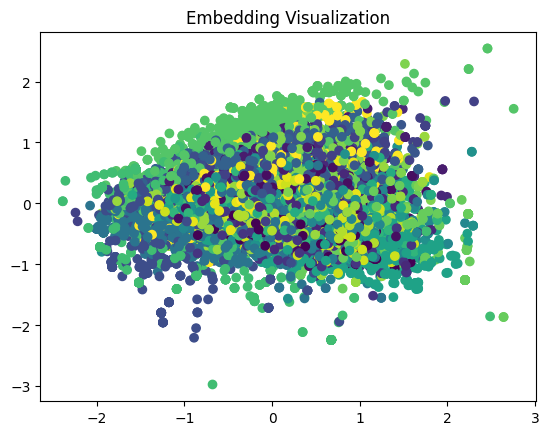

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensionality
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_train_emb)

# Convert y_train to numerical labels using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)

# Plot
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train_num) # Use numerical labels for color
plt.title("Embedding Visualization")
plt.show()

## Deep Learning models

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

### dense layers
CONCLUSION: After trying it, we will cancel its use because for new tickets the outputs are bad.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import joblib
import numpy as np
import os


# ================== TRAINING ================== #

# Convert labels to numerical using LabelEncoder
label_encoder = LabelEncoder() # Initialize LabelEncoder if not already done
y_train_enc = label_encoder.fit_transform(y_train) # Fit and transform y_train
y_test_enc = label_encoder.transform(y_test) # Transform y_test

y_train_onehot = tf.keras.utils.to_categorical(y_train_enc, num_classes=len(label_encoder.classes_))
y_test_onehot = tf.keras.utils.to_categorical(y_test_enc, num_classes=len(label_encoder.classes_))
# ------------------------------------------------------
# Step 1: Preprocess Text & Tokenize
# ------------------------------------------------------
# Assume X_train, X_test, y_train, y_test are predefined
max_words = 10000  # Vocabulary size
max_len = 100      # Max sequence length

# Tokenize text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# ------------------------------------------------------
# Step 2: Build Neural Network with Embeddings
# ------------------------------------------------------
embedding_dim = 64  # Embedding vector size

model = Sequential([
    # Embedding layer (learns embeddings during training)
    Embedding(
        input_dim=max_words,     # Vocabulary size
        output_dim=embedding_dim,  # Vector dimension
        input_length=max_len     # Input sequence length
    ),

    # Flatten embeddings into 1D vector
    Flatten(),

    # Fully connected (dense) layers
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),

    # Output layer (adjust for multi-label: use sigmoid)
    Dense(len(label_encoder.classes_), activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label
    metrics=['accuracy']
)

# Add Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_padded, y_train_onehot,
    epochs=50,  # Increased epochs since we're using early stopping
    batch_size=32,
    validation_data=(X_test_padded, y_test_onehot),
    callbacks=[early_stop]
)

# ================== SAVING ================== #
save_dir = '/content/drive/MyDrive/support_ticket_model'
os.makedirs(save_dir, exist_ok=True)

# Save full pipeline
model.save(f'{save_dir}/model.h5')
joblib.dump(tokenizer, f'{save_dir}/tokenizer.pkl')
joblib.dump(label_encoder, f'{save_dir}/label_encoder.pkl')

# Evaluate
test_loss, test_acc = model.evaluate(X_test_padded, y_test_onehot)
print(f"Test Accuracy: {test_acc}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


616/616 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.0700 - loss: 0.2376 - val_accuracy: 0.5137 - val_loss: 0.0887
Epoch 2/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5008 - loss: 0.0825 - val_accuracy: 0.9265 - val_loss: 0.0309
Epoch 3/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8341 - loss: 0.0390 - val_accuracy: 0.9763 - val_loss: 0.0147
Epoch 4/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9162 - loss: 0.0239 - val_accuracy: 0.9813 - val_loss: 0.0085
Epoch 5/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9454 - loss: 0.0161 - val_accuracy: 0.9842 - val_loss: 0.0067
Epoch 6/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9562 - loss: 0.0131 - val_accuracy: 0.9854 - val_loss: 0.0052
Epoch 7/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9660 - loss: 0.0100 - val_accuracy: 0.9884 - val_loss: 0.0041
Epoch 8/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9794 - loss: 0.0066 - val_accurac

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9940 - loss: 0.0018
Test Accuracy: 0.9920844435691833


In [ ]:
import pandas as pd
import numpy as np

# Sample DataFrame (replace with your actual data)
data = {
    'Ticket #': [1, 2, 3,4,5],
    'Ticket': [
        "I want to cancel my order and get a refund because I never received it.",
        "Can you help me track my recent order? Also, I need to change my shipping address.",
        "I forgot my password and now my payment isn't going through. Help!",
        "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
        "I tried to contact support, but no human agent responded. My payment also failed!"
    ],
    'Correct Categories': [
      ["cancel_order", "get_refund"],
      ["track_order", "change_shipping_address"],
      ["account_recover_password", "payment_issue"],
      ["delivery_options", "delete_account"],
      ["contact_human_agent", "payment_issue"]
    ]
}
df = pd.DataFrame(data)

# ================== PREDICTION ================== #
def predict_ticket(text):
    # Load components
    model = load_model(f'{save_dir}/model.h5')
    tokenizer = joblib.load(f'{save_dir}/tokenizer.pkl')
    label_encoder = joblib.load(f'{save_dir}/label_encoder.pkl')

    # Preprocess
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Predict
    probs = model.predict(padded)
    main_category = label_encoder.inverse_transform([np.argmax(probs)])

    # Get top 3 predictions
    top3_indices = np.argsort(probs[0])[-3:][::-1]
    top3_categories = label_encoder.inverse_transform(top3_indices)
    top3_probs = probs[0][top3_indices]

    return {
        "main_category": main_category[0],
        "top3_predictions": list(zip(top3_categories, top3_probs))
    }

# ================== PREDICTION POPULATION ================== #
# Add prediction columns to DataFrame
df['Predicted Category'] = ""
df['Top 3 Predictions'] = ""

for idx, row in df.iterrows():
    try:
        prediction = predict_ticket(row['Ticket'])
        df.at[idx, 'Predicted Category'] = prediction['main_category']

        # Format top predictions as "category (prob%), category (prob%)"
        top3_str = ", ".join([f"{cat} ({prob:.2%})" for cat, prob in prediction['top3_predictions']])
        df.at[idx, 'Top 3 Predictions'] = top3_str

    except Exception as e:
        df.at[idx, 'Top 3 Predictions'] = "Not Available"
        print(f"Error processing Ticket #{row['Ticket #']}: {str(e)}")

# ================== TEST FUNCTION ================== #
def test_function(row):
    """
    Checks if categories in 'Correct Categories' are in 'Top Predictions'
    Returns "Correct (in top X)" or 0
    """
    if row['Top 3 Predictions'] == "Not Available":
        return 0

    try:
        # Convert string representation of list to actual list
        correct_categories = eval(row['Correct Categories'])
        top_predictions = [p.split(' (')[0] for p in row['Top 3 Predictions'].split(', ')]

        # Check if all correct categories are in top predictions
        if all(cat in top_predictions for cat in correct_categories):
            # Check if all in top 2
            if all(cat in top_predictions[:2] for cat in correct_categories):
                return "Correct (in top 2)"
            return "Correct (in top 3)"
        return 0
    except:
        return 0

# Add Test Result column
df['Test Result'] = df.apply(test_function, axis=1)

# ================== FINAL TABLE ================== #
print("\nFinal Results Table:")
print(df[['Ticket #', 'Ticket', 'Predicted Category',
          'Top 3 Predictions', 'Correct Categories', 'Test Result']])
df.to_csv('dense_layers_final_results.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

Final Results Table:
   Ticket #                                             Ticket  \
0         1  I want to cancel my order and get a refund bec...   
1         2  Can you help me track my recent order? Also, I...   
2         3  I forgot my password and now my payment isn't ...   
3         4  Where can I see available delivery options? Al...   
4         5  I tried to contact support, but no human agent...   

         Predicted Category  \
0              cancel_order   
1               track_order   
2  account_recover_password   
3       contact_human_agent   
4  contact_customer_service   

                                   Top 3 Predictions  \
0  cancel_order (82.22%), delete_account (7.02%),...   
1  track_order (35.74%), edit_account (21.76%), c...   
2  account_recover_password (97.92%), delete_acco...   
3  contact_human_agent (55.97%), change_order (23...   
4  contact_customer_service (97.89%), get_invoice...   

                  

Text(0, 0.5, 'Accuracy')

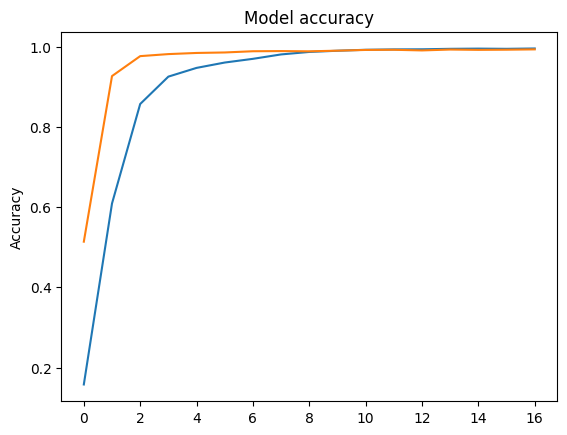

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict classes
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test_enc, y_pred_classes))

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.99      0.99      0.99       191
           2       0.99      0.96      0.98       102
           3       0.98      0.98      0.98       166
           4       1.00      0.99      1.00       191
           5       1.00      1.00      1.00       202
           6       0.99      1.00      0.99       211
           7       0.99      0.99      0.99       199
           8       0.99      0.98      0.99       192
           9       0.99      0.99      0.99       198
          10       1.00      1.00      1.00       211
          11       0.99      0.97      0.98       175
          12       0.97      1.00      0.99       193
          13       0.97      0.99      0.98       117
          14       1.00      1.00      1.00       209
          15       0.99      1.00      0.99       147
          16       1.00      1.00      1

### LSTM (Long Short-Term Memory)

LSTM model : tokenizes the text, pads sequences, trains an LSTM network, and evaluates accuracy.



---



*   Instead of using pd.factorize(), use LabelEncoder to ensure consistency

*  Modify the model to include Dropout layers and L2 Regularization to Reduce Overfitting
*   Use More Epochs with Early Stopping




---



In [ ]:
import numpy as np
# Calculate average ticket length
avg_len = np.mean([len(ticket.split()) for ticket in X_train])
print(f"Average ticket length: {avg_len}")  # Use this to guide max_len

Average ticket length: 4.335650497259996


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Deep Learning - LSTM Model
max_words = 5000  # Vocabulary size
max_len = 20  # Maximum length of a sequence

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Build LSTM Model
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.3),  # Additional dropout
    Dense(len(set(y_train)), activation='softmax', kernel_regularizer=l2(0.01))  # Apply L2 regularization
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM Model
# lstm_model.fit(X_train_seq, y_train_cat, epochs=5, batch_size=32, validation_data=(X_test_seq, y_test_cat))
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_model.fit(
    X_train_seq, y_train_enc,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_seq, y_test_enc),
    callbacks=[early_stop]
)

# Evaluate LSTM Model
y_pred_lstm = lstm_model.predict(X_test_seq).argmax(axis=1)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


616/616 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - accuracy: 0.2303 - loss: 3.4291 - val_accuracy: 0.8675 - val_loss: 1.1947
Epoch 2/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.8879 - loss: 1.1799 - val_accuracy: 0.9750 - val_loss: 0.8230
Epoch 3/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 101s 111ms/step - accuracy: 0.9658 - loss: 0.8830 - val_accuracy: 0.9838 - val_loss: 0.6911
Epoch 4/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 73s 97ms/step - accuracy: 0.9779 - loss: 0.7638 - val_accuracy: 0.9852 - val_loss: 0.6390
Epoch 5/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - accuracy: 0.9800 - loss: 0.7132 - val_accuracy: 0.9852 - val_loss: 0.6026
Epoch 6/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 66s 107ms/step - accuracy: 0.9820 - loss: 0.6731 - val_accuracy: 0.9870 - val_loss: 0.5749
Epoch 7/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - accuracy: 0.9837 - loss: 0.6445 - val_accuracy: 0.9882 - val_loss: 0.5532
Epoch 8/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 84s 82ms/step - accuracy: 0.9862 - loss: 0.6175 - val_accu

In [ ]:
# Add this import at the top of the cell
from sklearn.metrics import accuracy_score, classification_report

print("\nLSTM Accuracy:", accuracy_score(y_test_enc, y_pred_lstm))
print(classification_report(y_test_enc, y_pred_lstm))


LSTM Accuracy: 0.9930992490359245
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       1.00      0.99      0.99       191
           2       0.98      0.97      0.98       102
           3       0.99      0.98      0.98       166
           4       0.98      0.99      0.99       191
           5       0.99      1.00      1.00       202
           6       1.00      1.00      1.00       211
           7       1.00      0.99      1.00       199
           8       1.00      0.99      0.99       192
           9       1.00      1.00      1.00       198
          10       1.00      1.00      1.00       211
          11       0.99      0.97      0.98       175
          12       0.98      0.99      0.99       193
          13       0.98      0.97      0.97       117
          14       1.00      1.00      1.00       209
          15       0.99      0.99      0.99       147
          16       1.00      1.00      1.00   

In [ ]:
import tensorflow as tf
import pickle

# Save LSTM Model
lstm_model.save("/content/drive/MyDrive/models55/lstm_model.h5")

# Save Tokenizer
with open("/content/drive/MyDrive/models55/tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)

# Save Label Encoder
with open("/content/drive/MyDrive/models55/label_encoder.pkl", "wb") as handle:
    pickle.dump(label_encoder, handle)

print("✅ Models, tokenizer, and label encoder saved successfully!")


✅ Models, tokenizer, and label encoder saved successfully!


### lstm + dense
CONCLUSION: After trying it, we will cancel its use because for new tickets the outputs are  bad.

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 580.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Parameters
max_words = 5000
max_len = 20
num_classes = len(label_encoder.classes_)  # Add this before model construction

# Preprocessing (unchanged)
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Label encoding (unchanged)
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Optimized model architecture
lstm_model = Sequential([
    # 1. Embedding layer (remove input_length to suppress warning)
    Embedding(max_words, 45),

    # 2. First LSTM layer with reduced regularization
    LSTM(128,  # Increased units for better representation
         return_sequences=True,
         dropout=0.2,  # Reduced from 0.3
         recurrent_dropout=0.2,
         kernel_regularizer=l2(0.001)),  # Reduced regularization

    # 3. BatchNormalization instead of Dropout
    tf.keras.layers.BatchNormalization(),

    # 4. Second LSTM layer
    LSTM(64,  # Reduced units
         dropout=0.2,
         recurrent_dropout=0.2,
         kernel_regularizer=l2(0.001)),

    # 5. Dense layer with adjusted architecture
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),  # Reduced dropout

    # Final output layer
    Dense(num_classes, activation='softmax')
])

# Custom optimizer configuration
optimizer = Adam(
    learning_rate=0.0005,  # Reduced learning rate
    clipvalue=0.5  # Gradient clipping
)

# Enhanced early stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Monitor accuracy instead of loss
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Calculate class weights for imbalanced data
class_counts = np.bincount(y_train_enc)
class_weights = {i: 1./(class_counts[i]/np.sum(class_counts)) for i in range(num_classes)}

# Train with class weights
history = lstm_model.fit(
    X_train_seq,
    y_train_enc,
    epochs=50,  # Increased epochs
    batch_size=64,  # Larger batch size
    validation_data=(X_test_seq, y_test_enc),
    callbacks=[early_stop],
    class_weight=class_weights  # Add class weighting
)

Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.3206 - loss: 67.6256 - val_accuracy: 0.8636 - val_loss: 1.7470
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.9630 - loss: 5.6754 - val_accuracy: 0.9866 - val_loss: 0.4838
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9867 - loss: 2.3970 - val_accuracy: 0.9931 - val_loss: 0.4527
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.9920 - loss: 1.6036 - val_accuracy: 0.9929 - val_loss: 0.4408
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.9941 - loss: 1.2207 - val_accuracy: 0.9927 - val_loss: 0.4252
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9952 - loss: 1.0318 - val_accuracy: 0.9951 - val_loss: 0.4076
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.9962 - loss: 0.8933 - val_accuracy: 0.9955 - val_loss: 0.3963
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9976 - loss: 0.7263 

In [ ]:
#Import the necessary libraries
from sklearn.metrics import accuracy_score, classification_report
y_pred_lstm=lstm_model.predict(X_test_seq).argmax(axis=1)

# test accuracy
print("\nLSTM Accuracy:", accuracy_score(y_test_enc, y_pred_lstm))
print(classification_report(y_test_enc, y_pred_lstm))

154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

LSTM Accuracy: 0.9951288816724173
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.99      0.99      0.99       191
           2       0.99      0.97      0.98       102
           3       1.00      0.99      1.00       166
           4       0.99      1.00      1.00       191
           5       1.00      1.00      1.00       202
           6       0.98      1.00      0.99       211
           7       1.00      0.99      1.00       199
           8       1.00      0.99      0.99       192
           9       1.00      0.99      1.00       198
          10       1.00      1.00      1.00       211
          11       0.99      0.99      0.99       175
          12       0.99      1.00      0.99       193
          13       0.99      0.98      0.99       117
          14       0.99      1.00      1.00       209
          15       1.00      1.00      1.00       147
    

In [ ]:
lstm_model.save("/content/lstm_model.h5")


In [ ]:
import pickle

with open("/content/tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)
with open("/content/label_encoder.pkl", "wb") as handle:
    pickle.dump(label_encoder, handle)

In [ ]:
import pandas as pd
import numpy as np
import pickle
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from ast import literal_eval  # Safer alternative to eval

# ================== CONFIGURATION ================== #
save_dir = "/content"  # Update with your actual path

# Load saved parameters

max_len = 20
max_words = 5000

# ================== PREDICTION FUNCTION ================== #
def predict_ticket(text):
    # Load components
    model = load_model(f'{save_dir}/lstm_model.h5')  # Updated extension
    with open(f'{save_dir}/tokenizer.pkl', 'rb') as handle:
        tokenizer = pickle.load(handle)
    with open(f'{save_dir}/label_encoder.pkl', 'rb') as handle:
        label_encoder = pickle.load(handle)

    # Preprocess with proper padding
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Predict with batch dimension
    probs = model.predict(padded, verbose=0)

    # Get predictions
    top3_indices = np.argsort(probs[0])[-3:][::-1]
    return {
        "main_category": label_encoder.inverse_transform([np.argmax(probs)])[0],
        "top3_predictions": list(zip(
            label_encoder.inverse_transform(top3_indices),
            np.round(probs[0][top3_indices], 4)  # Rounded probabilities
        ))
    }

# ================== TEST FUNCTION IMPROVEMENTS ================== #
def test_function(row):
    """Safer implementation with error handling"""
    if row['Top 3 Predictions'] == "Not Available":
        return "Error"

    try:
        correct_categories = literal_eval(row['Correct Categories'])
        top_predictions = [p[0] for p in row['top3_predictions_raw']]

        # Check presence in predictions
        matches = [cat in top_predictions for cat in correct_categories]

        if not all(matches):
            return "Partial" if any(matches) else "None"

        # Check positions
        positions = [top_predictions.index(cat)+1 for cat in correct_categories]
        return f"All correct (max position: {max(positions)})"

    except Exception as e:
        print(f"Error in test_function: {str(e)}")
        return "Error"

# ================== DATA PROCESSING ================== #
# Sample DataFrame (now with raw predictions column)
data = {
    'Ticket #': [1, 2, 3,4,5],
    'Ticket': [
        "I want to cancel my order and get a refund because I never received it.",
        "Can you help me track my recent order? Also, I need to change my shipping address.",
        "I forgot my password and now my payment isn't going through. Help!",
        "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
        "I tried to contact support, but no human agent responded. My payment also failed!"
    ],
    'Correct Categories': [
      ["cancel_order", "get_refund"],
      ["track_order", "change_shipping_address"],
      ["account_recover_password", "payment_issue"],
      ["delivery_options", "delete_account"],
      ["contact_human_agent", "payment_issue"]
    ]
}
df = pd.DataFrame(data)


# Add prediction columns
df['top3_predictions_raw'] = None
df['Predicted Category'] = ""
df['Top 3 Predictions'] = ""

for idx, row in df.iterrows():
    try:
        prediction = predict_ticket(row['Ticket'])
        df.at[idx, 'top3_predictions_raw'] = prediction['top3_predictions']
        df.at[idx, 'Predicted Category'] = prediction['main_category']

        # Format with percentage
        formatted = [f"{cat} ({prob:.2%})" for cat, prob in prediction['top3_predictions']]
        df.at[idx, 'Top 3 Predictions'] = ", ".join(formatted)

    except Exception as e:
        print(f"Error processing Ticket #{row['Ticket #']}: {str(e)}")
        df.at[idx, 'Top 3 Predictions'] = "Not Available"

# Add Test Result column
df['Test Result'] = df.apply(test_function, axis=1)

# ================== FINAL OUTPUT ================== #
print("\nFinal Results Table:")
result_cols = ['Ticket #', 'Ticket', 'Predicted Category',
               'Top 3 Predictions', 'Correct Categories', 'Test Result']
print(df[result_cols])
df.to_csv('classification_results.csv', index=False)

Error in test_function: malformed node or string: ['cancel_order', 'get_refund']
Error in test_function: malformed node or string: ['track_order', 'change_shipping_address']
Error in test_function: malformed node or string: ['account_recover_password', 'payment_issue']
Error in test_function: malformed node or string: ['delivery_options', 'delete_account']
Error in test_function: malformed node or string: ['contact_human_agent', 'payment_issue']

Final Results Table:
   Ticket #                                             Ticket  \
0         1  I want to cancel my order and get a refund bec...   
1         2  Can you help me track my recent order? Also, I...   
2         3  I forgot my password and now my payment isn't ...   
3         4  Where can I see available delivery options? Al...   
4         5  I tried to contact support, but no human agent...   

         Predicted Category  \
0  contact_customer_service   
1   change_shipping_address   
2       check_refund_policy   
3      

### Transformers (BERT)

In [ ]:
!pip install transformers tensorflow

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import numpy as np
from transformers import AdamWeightDecay
import tensorflow as tf

# Transformer-based BERT Model
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')


def encode_texts(texts):
    encoded = tokenizer_bert(texts.tolist(), padding=True, truncation=True, max_length=100, return_tensors="tf")
    return encoded['input_ids'], encoded['attention_mask']


X_train_input_ids, X_train_attention_mask = encode_texts(X_train)
X_test_input_ids, X_test_attention_mask = encode_texts(X_test)


bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)), from_pt=True)

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)
bert_model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train BERT Model


bert_model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train_enc,
    epochs=6, batch_size=16,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test_enc)
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
1232/1232 [==============================] - 160s 115ms/step - loss: 0.6288 - accuracy: 0.9026 - val_loss: 0.0454 - val_accuracy: 0.9945
Epoch 2/6
1232/1232 [==============================] - 139s 113ms/step - loss: 0.0316 - accuracy: 0.9966 - val_loss: 0.0186 - val_accuracy: 0.9965
Epoch 3/6
1232/1232 [==============================] - 140s 114ms/step - loss: 0.0144 - accuracy: 0.9980 - val_loss: 0.0214 - val_accuracy: 0.9955
Epoch 4/6
1232/1232 [==============================] - 139s 113ms/step - loss: 0.0081 - accuracy: 0.9989 - val_loss: 0.0161 - val_accuracy: 0.9972
Epoch 5/6
1232/1232 [==============================] - 139s 113ms/step - loss: 0.0092 - accuracy: 0.9983 - val_loss: 0.0313 - val_accuracy: 0.9921
Epoch 6/6
1232/1232 [==============================] - 138s 112ms/step - loss: 0.0119 - accuracy: 0.9973 - val_loss: 0.0158 - val_accuracy: 0.9970


In [ ]:
import numpy as np
# Evaluate BERT Model
y_pred_bert = np.argmax(bert_model.predict([X_test_input_ids, X_test_attention_mask]).logits, axis=1)
print("\nBERT Accuracy:", accuracy_score(y_test_enc, y_pred_bert))

154/154 [==============================] - 9s 42ms/step

BERT Accuracy: 0.9969555510452608


In [ ]:
# Save BERT Model
bert_model.save_pretrained("/content/drive/My Drive/models2/bert_model_10")
tokenizer_bert.save_pretrained("/content/drive/My Drive/models2/bert_tokenizer_10")
print("Saved BERT model and tokenizer to Drive.")

Saved BERT model and tokenizer to Drive.


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
# Load Tokenizer & Model
tokenizer_bert = BertTokenizer.from_pretrained("/content/drive/MyDrive/models2/bert_tokenizer_10")
bert_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/models2/bert_model_10")
print("Loaded BERT model and tokenizer from Drive.")

Some layers from the model checkpoint at /content/drive/MyDrive/models2/bert_model_10 were not used when initializing TFBertForSequenceClassification: ['dropout_189']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/models2/bert_model_10.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Loaded BERT model and tokenizer from Drive.


# make predictions on new tickets.

In [ ]:
import joblib # Import the joblib library

# Load ML Models
ml_models = {
    "Logistic Regression": joblib.load("/content/drive/MyDrive/models4/Logistic Regression.pkl"),
    "SVM": joblib.load("/content/drive/MyDrive/models4/SVM.pkl"),
    "SGD": joblib.load("/content/drive/MyDrive/models4/SGD.pkl"),
    "Random Forest": joblib.load("/content/drive/MyDrive/models4/Random Forest.pkl"),
    "Naïve Bayes": joblib.load("/content/drive/MyDrive/models4/Naïve Bayes.pkl")
}

# Load TF-IDF Vectorizer
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/models4/tfidf_vectorizer.pkl")

def predict_with_ml(text):
    text_tfidf = tfidf_vectorizer.transform([text])
    predictions = {name: model.predict(text_tfidf)[0] for name, model in ml_models.items()}
    return predictions


new_ticket = [
        "I want to cancel my order and get a refund because I never received it.",
        "Can you help me track my recent order? Also, I need to change my shipping address.",
        "I forgot my password and now my payment isn't going through. Help!",
        "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
        "I tried to contact support, but no human agent responded. My payment also failed!",
]
ml_predictions = [predict_with_ml(ticket) for ticket in new_ticket]

print("ML Model Predictions:", ml_predictions)

ML Model Predictions: [{'Logistic Regression': 'cancel_order', 'SVM': 'cancel_order', 'SGD': 'cancel_order', 'Random Forest': 'cancel_order', 'Naïve Bayes': 'get_refund'}, {'Logistic Regression': 'change_shipping_address', 'SVM': 'change_shipping_address', 'SGD': 'change_shipping_address', 'Random Forest': 'change_shipping_address', 'Naïve Bayes': 'change_shipping_address'}, {'Logistic Regression': 'account_recover_password', 'SVM': 'account_recover_password', 'SGD': 'account_recover_password', 'Random Forest': 'payment_issue', 'Naïve Bayes': 'account_recover_password'}, {'Logistic Regression': 'delete_account', 'SVM': 'delete_account', 'SGD': 'delete_account', 'Random Forest': 'delete_account', 'Naïve Bayes': 'delivery_options'}, {'Logistic Regression': 'contact_human_agent', 'SVM': 'contact_human_agent', 'SGD': 'contact_human_agent', 'Random Forest': 'payment_issue', 'Naïve Bayes': 'contact_human_agent'}]


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Tokenizer & Label Encoder
with open("/content/drive/MyDrive/models55/tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

with open("/content/drive/MyDrive/models2/label_encoder.pkl", "rb") as handle:
    label_encoder = pickle.load(handle)

# Load Trained Models
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/models55/lstm_model.h5")


print("✅ Models, tokenizer, and label encoder loaded successfully!")

# Function to Predict with Deep Learning Models
def predict_with_dl(model, text):
    seq = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=100)
    pred_index = model.predict(seq).argmax(axis=1)
    pred_label = label_encoder.inverse_transform(pred_index)
    return pred_label[0]  # Extract string label

# Example Prediction
new_ticket = [
        "I want to cancel my order and get a refund because I never received it.",
        "Can you help me track my recent order? Also, I need to change my shipping address.",
        "I forgot my password and now my payment isn't going through. Help!",
        "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
        "I tried to contact support, but no human agent responded. My payment also failed!",
]

lstm_prediction =[predict_with_dl(lstm_model, ticket) for ticket in new_ticket]


print("LSTM Prediction:", lstm_prediction)



✅ Models, tokenizer, and label encoder loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
LSTM Prediction: ['get_invoice', 'track_order', 'account_recover_password', 'delivery_options', 'contact_human_agent']


In [ ]:
!pip install tf-keras

In [ ]:

from transformers import BertTokenizer, TFBertForSequenceClassification
import numpy as np

# Load Tokenizer & Model
tokenizer_bert = BertTokenizer.from_pretrained("/content/drive/MyDrive/models2/bert_tokenizer_10")
bert_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/models2/bert_model_10")

def predict_with_bert(text):
    inputs = tokenizer_bert([text], padding=True, truncation=True, max_length=100, return_tensors="tf")
    logits = bert_model(inputs["input_ids"]).logits
    pred1 = np.argmax(logits, axis=1)
    pred = label_encoder.inverse_transform(pred1)
    return pred

new_ticket = [
        "I want to cancel my order and get a refund because I never received it.",
        "Can you help me track my recent order? Also, I need to change my shipping address.",
        "I forgot my password and now my payment isn't going through. Help!",
        "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
        "I tried to contact support, but no human agent responded. My payment also failed!",
]
bert_prediction = [predict_with_bert(ticket) for ticket in new_ticket]
print("BERT Prediction:", bert_prediction)


Some layers from the model checkpoint at /content/drive/MyDrive/models2/bert_model_10 were not used when initializing TFBertForSequenceClassification: ['dropout_189']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/models2/bert_model_10.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


BERT Prediction: [array(['get_refund'], dtype=object), array(['change_shipping_address'], dtype=object), array(['payment_issue'], dtype=object), array(['delete_account'], dtype=object), array(['payment_issue'], dtype=object)]


In [ ]:
import pandas as pd
import numpy as np

# Assuming ml_predictions is a list of dictionaries
ml_predictions_df = pd.DataFrame(ml_predictions)  # Convert ml_predictions to DataFrame

# Convert other lists to DataFrames with appropriate column names
bert_prediction_df = pd.DataFrame(bert_prediction, columns=['BERT'])
lstm_prediction_df = pd.DataFrame(lstm_prediction, columns=['LSTM'])

# Create a DataFrame with the original tickets
tickets_df = pd.DataFrame(new_ticket, columns=['Ticket'])
correct_df = pd.DataFrame({'correct':[
        ["cancel_order", "get_refund"],
        ["track_order", "change_shipping_address"],
        ["account_recover_password", "payment_issue"],
        ["delivery_options", "delete_account"],
        ["contact_human_agent", "payment_issue"]

]})



# Now concatenate all the DataFrames
all_predictions_df = pd.concat([tickets_df, correct_df,bert_prediction_df, lstm_prediction_df, ml_predictions_df], axis=1)

# 1. Add "(correct)" or "(not found)"
for col in ['BERT', 'LSTM', *ml_predictions_df.columns]:  # Include all prediction columns
    all_predictions_df[col] = all_predictions_df.apply(
        lambda row: row[col] + ' (correct)' if row[col] in row['correct'] else row[col] + ' (not found)',
        axis=1
    )

# 2. Calculate and add accuracy row
accuracy_row = {'Ticket': 'Accuracy'}
for col in ['BERT', 'LSTM', *ml_predictions_df.columns]:
    accuracy = (all_predictions_df[col].str.contains('(correct)').sum() / len(all_predictions_df)) * 100
    accuracy_row[col] = f"{accuracy:.2f}%"

all_predictions_df = pd.concat([all_predictions_df, pd.DataFrame([accuracy_row])], ignore_index=True)

# Display the DataFrame
print(all_predictions_df)
all_predictions_df.to_csv('all_predictions.csv')


                                              Ticket  \
0  I want to cancel my order and get a refund bec...   
1  Can you help me track my recent order? Also, I...   
2  I forgot my password and now my payment isn't ...   
3  Where can I see available delivery options? Al...   
4  I tried to contact support, but no human agent...   
5                                           Accuracy   

                                     correct  \
0                 [cancel_order, get_refund]   
1     [track_order, change_shipping_address]   
2  [account_recover_password, payment_issue]   
3         [delivery_options, delete_account]   
4       [contact_human_agent, payment_issue]   
5                                        NaN   

                                BERT                                LSTM  \
0               get_refund (correct)             get_invoice (not found)   
1  change_shipping_address (correct)               track_order (correct)   
2            payment_issue (correct)  acco

<ipython-input-52-faac286e3184>:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  accuracy = (all_predictions_df[col].str.contains('(correct)').sum() / len(all_predictions_df)) * 100


# Thinking and planning for multiclass

In [ ]:
import joblib
import numpy as np

# Load ML Models
ml_models = {
    "Logistic Regression": joblib.load("/content/drive/MyDrive/models4/Logistic Regression.pkl"),
    "SVM": joblib.load("/content/drive/MyDrive/models4/SVM.pkl"),
    "SGD": joblib.load("/content/drive/MyDrive/models4/SGD.pkl"),
    "Random Forest": joblib.load("/content/drive/MyDrive/models4/Random Forest.pkl"),
    "Naïve Bayes": joblib.load("/content/drive/MyDrive/models4/Naïve Bayes.pkl")
}

# Load TF-IDF Vectorizer
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/models4/tfidf_vectorizer.pkl")

def predict_with_ml(text):
    """
    Predict the category of a ticket using multiple ML models.
    Returns both predicted labels and probability scores.
    """
    text_tfidf = tfidf_vectorizer.transform([text])
    predictions = {}

    for name, model in ml_models.items():
        if hasattr(model, "predict_proba"):  # Models supporting probability prediction
            probs = model.predict_proba(text_tfidf)[0]
        elif hasattr(model, "decision_function"):  # SVM uses decision scores
            probs = model.decision_function(text_tfidf)
            probs = np.exp(probs) / np.sum(np.exp(probs))  # Softmax normalization for comparability
        else:
            probs = None  # Model does not support probabilities

        predicted_label = model.predict(text_tfidf)[0]

        # Store results
        predictions[name] = {
            "predicted_label": predicted_label,
            "probabilities": probs.tolist() if probs is not None else "Not Available"
        }

    return predictions

# Test on long multi-sentence tickets
new_tickets =  [
        "I want to cancel my order and get a refund because I never received it.",
        "Can you help me track my recent order? Also, I need to change my shipping address.",
        "I forgot my password and now my payment isn't going through. Help!",
        "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
        "I tried to contact support, but no human agent responded. My payment also failed!",
]

ml_predictions = [predict_with_ml(ticket) for ticket in new_tickets]

# Print results
for i, (ticket, prediction) in enumerate(zip(new_tickets, ml_predictions)):
    print(f"\n=== Ticket {i+1} ===")
    print(f"Ticket Text: {ticket}")
    for model_name, result in prediction.items():
        print(f"\nModel: {model_name}")
        print(f"Predicted Category: {result['predicted_label']}")
        print(f"Probabilities: {result['probabilities']}")  # Prints full probability distribution





=== Ticket 1 ===
Ticket Text: I want to cancel my order and get a refund because I never received it.

Model: Logistic Regression
Predicted Category: cancel_order
Probabilities: [0.018610193193272683, 0.014506798881169234, 0.21857314510258122, 0.05077567184419844, 0.012932705655677404, 0.014004008521890906, 0.008675671225298063, 0.011030838204098233, 0.04079038210720372, 0.012978506847787445, 0.023433779972926724, 0.01441272550722799, 0.07488743747150299, 0.03598394230869284, 0.014768395080975157, 0.009905456729896588, 0.013910822756914335, 0.016389418779446698, 0.0824091345236361, 0.16881177401663638, 0.018966784971881482, 0.012909716733619443, 0.034751835115959515, 0.01111057994301848, 0.005589898027094391, 0.02983926560027562, 0.029041110877117898]

Model: SVM
Predicted Category: cancel_order
Probabilities: [0.01100020959216749, 0.00870148267545463, 0.2519865919639513, 0.06732602317195928, 0.012019996299887438, 0.010903357684448016, 0.023480383230239963, 0.008486034567771507, 0.023

In [ ]:
import pandas as pd
import numpy as np

# Prepare data for the table
table_data = []
for i, (ticket, prediction) in enumerate(zip(new_tickets, ml_predictions)):
    for model_name, result in prediction.items():
        # Extract probabilities
        if result['probabilities'] != "Not Available":
            probs = result['probabilities']

            # Handle nested list issue for SVM
            if isinstance(probs, list) and isinstance(probs[0], list):
                probs = probs[0]  # Extract first (and only) row for SVM(untill retrain svm with prob)

            probs = np.array(probs)  # Convert to NumPy array for safe indexing
            top_indices = np.argsort(probs)[-3:][::-1]  # Indices of top 3 predictions

            top_probs = [probs[j] for j in top_indices]  # Extract top probability values
            top_categories = label_encoder.inverse_transform(top_indices).tolist()  # Convert indices to category labels

            # Format predictions properly
            top_predictions_str = ', '.join([
                f"{top_categories[k]} ({top_probs[k]:.2f})" for k in range(len(top_categories))
            ])

        else:
            top_predictions_str = "Not Available"

        # Add row to table data
        table_data.append([i + 1, model_name, result['predicted_label'], top_predictions_str])

# Create pandas DataFrame
table_df = pd.DataFrame(table_data, columns=['Ticket #', 'Model', 'Predicted Category', 'Top Predictions (Category & Probability)'])

# Display the table
print(table_df)

# Save to CSV
table_df.to_csv('prediction_table.csv', index=False)


    Ticket #                Model        Predicted Category  \
0          1  Logistic Regression              cancel_order   
1          1                  SVM              cancel_order   
2          1                  SGD              cancel_order   
3          1        Random Forest              cancel_order   
4          1          Naïve Bayes                get_refund   
5          2  Logistic Regression   change_shipping_address   
6          2                  SVM   change_shipping_address   
7          2                  SGD   change_shipping_address   
8          2        Random Forest   change_shipping_address   
9          2          Naïve Bayes   change_shipping_address   
10         3  Logistic Regression  account_recover_password   
11         3                  SVM  account_recover_password   
12         3                  SGD  account_recover_password   
13         3        Random Forest             payment_issue   
14         3          Naïve Bayes  account_recover_pass

In [ ]:
import tensorflow as tf
import pickle
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Tokenizer & Label Encoder
with open("/content/drive/MyDrive/models55/tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

with open("/content/drive/MyDrive/models5/label_encoder.pkl", "rb") as handle:
    label_encoder = pickle.load(handle)

# Load Trained Model
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/models55/lstm_model.h5")

print("✅ LSTM Model, tokenizer, and label encoder loaded successfully!")

# Function to Predict with LSTM and Extract Last-Layer Probabilities
def predict_with_lstm(model, text):
    seq = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=100)
    probabilities = model.predict(seq)[0]  # Extract softmax probabilities

    pred_index = np.argmax(probabilities)  # Get index of highest probability
    pred_label = label_encoder.inverse_transform([pred_index])[0]  # Convert to class label

    # Sort probabilities in descending order and extract top 3 classes
    top_indices = np.argsort(probabilities)[-3:][::-1]
    top_categories = label_encoder.inverse_transform(top_indices)  # Convert to class names
    top_probs = probabilities[top_indices]  # Extract corresponding probabilities

    # Format as dictionary
    result = {
        "Predicted Label": pred_label,
        "Probabilities": dict(zip(top_categories, top_probs))
    }
    return result

# Example Predictions for Multiple Tickets
new_tickets =  [
        "I want to cancel my order and get a refund because I never received it.",
        "Can you help me track my recent order? Also, I need to change my shipping address.",
        "I forgot my password and now my payment isn't going through. Help!",
        "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
        "I tried to contact support, but no human agent responded. My payment also failed!",
]

# Get predictions
lstm_predictions = [predict_with_lstm(lstm_model, ticket) for ticket in new_tickets]

# Print Results
for i, (ticket, prediction) in enumerate(zip(new_tickets, lstm_predictions), 1):
    print(f"=== Ticket {i} ===")
    print(f"Ticket Text: {ticket}\n")
    print(f"Predicted Category: {prediction['Predicted Label']}")
    print("Top Predictions:")
    for category, prob in prediction["Probabilities"].items():
        print(f"- {category}: {prob:.4f}")
    print("\n" + "="*50 + "\n")


✅ LSTM Model, tokenizer, and label encoder loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
=== Ticket 1 ===
Ticket Text: I want to cancel my order and get a refund because I never received it.

Predicted Category: get_invoice
Top Predictions:
- get_invoice: 0.4152
- get_refund: 0.3076
- feedback_review: 0.0401


=== Ticket 2 ===
Ticket Text: Can you help me track my recent order? Also, I need to change my shipping address.

Predicted Category: track_order
Top Predictions:
- track_order: 0.5839
- delivery_period: 0.1187
- delivery_options: 0.0442


=== Ticket 3 ===
Ticket Text: I forgot my password and now my payment isn't going through. Help!

Predicted Category: account_recover_password
Top Predictions:
- account_recover_password: 0.5590
- check_payment_methods: 0.1456
- delivery_period: 0.0747


=== Ticket 4 ===
Ticket Te

In [ ]:
import pandas as pd
import joblib
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Tokenizer & Label Encoder
with open("/content/drive/MyDrive/models55/tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

with open("/content/drive/MyDrive/models2/label_encoder.pkl", "rb") as handle:
    label_encoder = pickle.load(handle)

# Load Trained Model
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/models55/lstm_model.h5")

def predict_with_lstm(model, text):
    seq = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=100)
    probabilities = model.predict(seq)[0]  # Extract softmax probabilities

    pred_index = np.argmax(probabilities)  # Get index of highest probability
    pred_label = label_encoder.inverse_transform([pred_index])[0]  # Convert to class label

    # Sort probabilities in descending order and extract top 3 classes
    top_indices = np.argsort(probabilities)[-3:][::-1]
    top_categories = label_encoder.inverse_transform(top_indices)  # Convert to class names
    top_probs = probabilities[top_indices]  # Extract corresponding probabilities

    # Format as dictionary
    result = {
        "Predicted Label": pred_label,
        "Probabilities": dict(zip(top_categories, top_probs))
    }
    return result


# Get predictions for LSTM
lstm_predictions = [predict_with_lstm(lstm_model, ticket) for ticket in new_tickets]

# Prepare data for the table
table_data = []
for i, (ticket, prediction) in enumerate(zip(new_tickets, ml_predictions)):
    for model_name, result in prediction.items():
        if result['probabilities'] != "Not Available":
            probs = result['probabilities']

            # Handle nested list issue for SVM
            if isinstance(probs, list) and isinstance(probs[0], list):
                probs = probs[0]  # Extract first (and only) row for SVM(before retrain with prob)

            probs = np.array(probs)  # Convert to NumPy array for safe indexing
            top_indices = np.argsort(probs)[-3:][::-1]  # Indices of top 3 predictions

            top_probs = [probs[j] for j in top_indices]  # Extract top probability values
            top_categories = label_encoder.inverse_transform(top_indices).tolist()  # Convert indices to category labels

            # Format predictions properly
            top_predictions_str = ', '.join([
                f"{top_categories[k]} ({top_probs[k]:.2f})" for k in range(len(top_categories))
            ])

        else:
            top_predictions_str = "Not Available"

        table_data.append([i + 1, ticket, model_name, result['predicted_label'], top_predictions_str])

    # Add LSTM prediction for the current ticket as the next row
    lstm_predicted_label = lstm_predictions[i]['Predicted Label']
    lstm_top_predictions_str = ', '.join([f"{cat} ({prob:.2f})" for cat, prob in lstm_predictions[i]['Probabilities'].items()])
    table_data.append([i + 1, ticket, 'LSTM', lstm_predicted_label, lstm_top_predictions_str])

# Create pandas DataFrame
table_df = pd.DataFrame(table_data, columns=['Ticket #', 'Ticket', 'Model', 'Predicted Category', 'Top Predictions (Category & Probability)'])

# Print results
print(table_df)

# Save to CSV
table_df.to_csv('merged_prediction_table_with_lstm.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
    Ticket #                                             Ticket  \
0          1  I want to cancel my order and get a refund bec...   
1          1  I want to cancel my order and get a refund bec...   
2          1  I want to cancel my order and get a refund bec...   
3          1  I want to cancel my order and get a refund bec...   
4          1  I want to cancel my order and get a refund bec...   
5          1  I want to cancel my order and get a refund bec...   
6          2  Can you help me track my recent order? Also, I...   
7          2  Can you help me track my recent order? Also, I...   
8          2  Can you help me track my recent order? Also, I...   
9          2  Can you help me track my recent order? Also, I...   
10         2  Can you help me track my recent order? Also, I...   
1

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import numpy as np
import tensorflow as tf
import pickle

# Load Tokenizer & Model
tokenizer_bert = BertTokenizer.from_pretrained("/content/drive/MyDrive/models2/bert_tokenizer")
bert_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/models2/bert_model")

# Load Label Encoder
with open("/content/drive/MyDrive/models2/label_encoder.pkl", "rb") as handle:
    label_encoder = pickle.load(handle)

print("✅ BERT Model, tokenizer, and label encoder loaded successfully!")

# Function to Predict with BERT and Extract Probabilities
def predict_with_bert(text):
    inputs = tokenizer_bert([text], padding=True, truncation=True, max_length=100, return_tensors="tf")
    logits = bert_model(inputs["input_ids"]).logits  # Get raw logits

    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]  # Convert logits to probabilities
    pred_index = np.argmax(probabilities)  # Get index of highest probability
    pred_label = label_encoder.inverse_transform([pred_index])[0]  # Convert to class label

    # Sort probabilities in descending order and extract top 3 classes
    top_indices = np.argsort(probabilities)[-3:][::-1]
    top_categories = label_encoder.inverse_transform(top_indices)  # Convert to class names
    top_probs = probabilities[top_indices]  # Extract corresponding probabilities

    # Format as dictionary
    result = {
        "Predicted Label": pred_label,
        "Probabilities": dict(zip(top_categories, top_probs))
    }
    return result

# Example Predictions for Multiple Tickets
new_tickets =  [
        "I want to cancel my order and get a refund because I never received it.",
        "Can you help me track my recent order? Also, I need to change my shipping address.",
        "I forgot my password and now my payment isn't going through. Help!",
        "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
        "I tried to contact support, but no human agent responded. My payment also failed!",
]

# Get predictions
bert_predictions = [predict_with_bert(ticket) for ticket in new_tickets]

# Print Results
for i, (ticket, prediction) in enumerate(zip(new_tickets, bert_predictions), 1):
    print(f"=== Ticket {i} ===")
    print(f"Ticket Text: {ticket}\n")
    print(f"Predicted Category: {prediction['Predicted Label']}")
    print("Top Predictions:")
    for category, prob in prediction["Probabilities"].items():
        print(f"- {category}: {prob:.4f}")
    print("\n" + "="*50 + "\n")


Some layers from the model checkpoint at /content/drive/MyDrive/models2/bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/models2/bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


✅ BERT Model, tokenizer, and label encoder loaded successfully!
=== Ticket 1 ===
Ticket Text: I want to cancel my order and get a refund because I never received it.

Predicted Category: get_refund
Top Predictions:
- get_refund: 0.8800
- cancel_order: 0.0905
- check_cancellation_fee: 0.0044


=== Ticket 2 ===
Ticket Text: Can you help me track my recent order? Also, I need to change my shipping address.

Predicted Category: change_shipping_address
Top Predictions:
- change_shipping_address: 0.9966
- edit_account: 0.0004
- set_up_shipping_address: 0.0003


=== Ticket 3 ===
Ticket Text: I forgot my password and now my payment isn't going through. Help!

Predicted Category: payment_issue
Top Predictions:
- payment_issue: 0.8376
- account_recover_password: 0.1131
- check_payment_methods: 0.0162


=== Ticket 4 ===
Ticket Text: Where can I see available delivery options? Also, I'd like to delete my account permanently.

Predicted Category: delete_account
Top Predictions:
- delete_account: 0.

In [ ]:
import pandas as pd
import joblib
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification



# Load Tokenizer & Model
tokenizer_bert = BertTokenizer.from_pretrained("/content/drive/MyDrive/models2/bert_tokenizer_10")
bert_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/models2/bert_model_10")

# Load Label Encoder
with open("/content/drive/MyDrive/models2/label_encoder.pkl", "rb") as handle:
    label_encoder = pickle.load(handle)

print("✅ BERT Model, tokenizer, and label encoder loaded successfully!")

# Load Tokenizer & Label Encoder
with open("/content/drive/MyDrive/models55/tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

with open("/content/drive/MyDrive/models2/label_encoder.pkl", "rb") as handle:
    label_encoder = pickle.load(handle)

# Load Trained Model
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/models55/lstm_model.h5")

def predict_with_lstm(model, text):
    seq = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=100)
    probabilities_lstm = model.predict(seq)[0]  # Extract softmax probabilities

    pred_index_lstm= np.argmax(probabilities_lstm)  # Get index of highest probability
    pred_label_lstm = label_encoder.inverse_transform([pred_index_lstm])[0]  # Convert to class label

    # Sort probabilities in descending order and extract top 3 classes
    top_indices = np.argsort(probabilities_lstm)[-3:][::-1]
    top_categories = label_encoder.inverse_transform(top_indices)  # Convert to class names
    top_probs = probabilities_lstm[top_indices]  # Extract corresponding probabilities

    # Format as dictionary
    result_lstm = {
        "Predicted Label_lstm": pred_label_lstm,
        "probabilities_lstm": dict(zip(top_categories, top_probs))
    }
    return result_lstm
# Function to Predict with BERT and Extract Probabilities
def predict_with_bert(text):
    inputs = tokenizer_bert([text], padding=True, truncation=True, max_length=100, return_tensors="tf")
    logits = bert_model(inputs["input_ids"]).logits  # Get raw logits

    probabilities_bert = tf.nn.softmax(logits, axis=1).numpy()[0]  # Convert logits to probabilities
    pred_index = np.argmax(probabilities_bert)  # Get index of highest probability
    pred_label = label_encoder.inverse_transform([pred_index])[0]  # Convert to class label

    # Sort probabilities in descending order and extract top 3 classes
    top_indices = np.argsort(probabilities_bert)[-3:][::-1]
    top_categories = label_encoder.inverse_transform(top_indices)  # Convert to class names
    top_probs = probabilities_bert[top_indices]  # Extract corresponding probabilities

    # Format as dictionary
    result_bert = {
        "Predicted Label_bert": pred_label,
        "probabilities_bert": dict(zip(top_categories, top_probs))
    }
    return result_bert

# Get predictions for LSTM
lstm_predictions = [predict_with_lstm(lstm_model, ticket) for ticket in new_tickets]
bert_predictions = [predict_with_bert(ticket) for ticket in new_tickets]

# Prepare data for the table
table_data = []
for i, (ticket, prediction) in enumerate(zip(new_tickets, ml_predictions)):
    for model_name, result in prediction.items():
        if result['probabilities'] != "Not Available":
            probs = result['probabilities']

            # Handle nested list issue for SVM
            if isinstance(probs, list) and isinstance(probs[0], list):
                probs = probs[0]  # Extract first (and only) row for SVM(before retrain with probs)

            probs = np.array(probs)  # Convert to NumPy array for safe indexing
            top_indices = np.argsort(probs)[-3:][::-1]  # Indices of top 3 predictions

            top_probs = [probs[j] for j in top_indices]  # Extract top probability values
            top_categories = label_encoder.inverse_transform(top_indices).tolist()  # Convert indices to category labels

            # Format predictions properly
            top_predictions_str = ', '.join([
                f"{top_categories[k]} ({top_probs[k]:.2f})" for k in range(len(top_categories))
            ])

        else:
            top_predictions_str = "Not Available"

        table_data.append([i + 1, ticket, model_name, result['predicted_label'], top_predictions_str])

    # Add LSTM prediction for the current ticket as the next row
    lstm_predicted_label = lstm_predictions[i]['Predicted Label_lstm']
    lstm_top_predictions_str = ', '.join([f"{cat} ({prob:.2f})" for cat, prob in lstm_predictions[i]['probabilities_lstm'].items()])
    table_data.append([i + 1, ticket, 'LSTM', lstm_predicted_label, lstm_top_predictions_str])
    # Add BERT prediction to the table
    bert_predicted_label = bert_predictions[i]['Predicted Label_bert'] # Access bert_predictions using the index 'i'
    bert_top_predictions_str = ', '.join([f"{cat} ({prob:.2f})" for cat, prob in bert_predictions[i]['probabilities_bert'].items()])  # Access bert_predictions
    table_data.append([i + 1, ticket, 'BERT', bert_predicted_label, bert_top_predictions_str]) # Append to table_data

# Create pandas DataFrame
table_df = pd.DataFrame(table_data, columns=['Ticket #', 'Ticket', 'Model', 'Predicted Category', 'Top Predictions (Category & Probability)'])

# Print results
print(table_df)

# Save to CSV
table_df.to_csv('merged_prediction_table_all.csv', index=False)

Some layers from the model checkpoint at /content/drive/MyDrive/models2/bert_model_10 were not used when initializing TFBertForSequenceClassification: ['dropout_189']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/models2/bert_model_10.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


✅ BERT Model, tokenizer, and label encoder loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
    Ticket #                                             Ticket  \
0          1  I want to cancel my order and get a refund bec...   
1          1  I want to cancel my order and get a refund bec...   
2          1  I want to cancel my order and get a refund bec...   
3          1  I want to cancel my order and get a refund bec...   
4          1  I want to cancel my order and get a refund bec...   
5          1  I want to cancel my order and get a refund bec...   
6          1  I want to cancel my order and get a refund bec...   
7          2  Can you help me track my recent order? Also, I...   
8          2  Can you help me track my recent order? Also, I...   
9          2  Can you help me track my recent order? Also, I...   
10         2  Can you help me track my recent order? Also, I...   
11

In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'table_df'
table_df = pd.read_csv('merged_prediction_table_all.csv')

# Define the correct categories
correct_categories = [
    ["cancel_order", "get_refund"],
    ["track_order", "change_shipping_address"],
    ["account_recover_password", "payment_issue"],
    ["delivery_options", "delete_account"],
    ["contact_human_agent", "payment_issue"]
]

# Add 'Correct Categories' column
table_df['Correct Categories'] = ''  # Initialize the column

# Assign correct categories based on Ticket #
for i in range(len(correct_categories)):
    table_df.loc[table_df['Ticket #'] == i + 1, 'Correct Categories'] = str(correct_categories[i])

# Display the updated DataFrame
print(table_df)

# Save the updated DataFrame
table_df.to_csv('merged_prediction_table_all_with_correct.csv', index=False)

    Ticket #                                             Ticket  \
0          1  I want to cancel my order and get a refund bec...   
1          1  I want to cancel my order and get a refund bec...   
2          1  I want to cancel my order and get a refund bec...   
3          1  I want to cancel my order and get a refund bec...   
4          1  I want to cancel my order and get a refund bec...   
5          1  I want to cancel my order and get a refund bec...   
6          1  I want to cancel my order and get a refund bec...   
7          2  Can you help me track my recent order? Also, I...   
8          2  Can you help me track my recent order? Also, I...   
9          2  Can you help me track my recent order? Also, I...   
10         2  Can you help me track my recent order? Also, I...   
11         2  Can you help me track my recent order? Also, I...   
12         2  Can you help me track my recent order? Also, I...   
13         2  Can you help me track my recent order? Also, I..

In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'table_df'
table_df = pd.read_csv('merged_prediction_table_all_with_correct.csv')

def test_function(row):
    """
    Checks if categories in 'Correct Categories' are in 'Top Predictions'.
    Returns "Correct" with bracket info (top 2 or 3) or 0.
    """
    correct_categories = eval(row['Correct Categories'])  # Convert string to list
    top_predictions_str = row['Top Predictions (Category & Probability)']

    if top_predictions_str == "Not Available":
        return 0  # Handle cases where probabilities aren't available untill retrain (retrain done)

    # Extract top categories from prediction string
    top_predictions = [pred.split(' (')[0] for pred in top_predictions_str.split(', ')]

    # Check if all correct categories are in top predictions
    all_correct_in_top = all(cat in top_predictions for cat in correct_categories)

    if all_correct_in_top:
        # Check if all correct categories are in top 2
        all_correct_in_top2 = all(cat in top_predictions[:2] for cat in correct_categories)
        if all_correct_in_top2:
            return "Correct (in top 2)"
        else:
            return "Correct (in top 3)"  # If not in top 2, but in top 3
    else:
        return 0  # If not all correct categories are in top predictions

# Apply the test function and create a new column
table_df['Test Result'] = table_df.apply(test_function, axis=1)

# Display the updated DataFrame
print(table_df)

# Save the updated DataFrame
table_df.to_csv('merged_prediction_table_all_with_correct_and_test.csv', index=False)

    Ticket #                                             Ticket  \
0          1  I want to cancel my order and get a refund bec...   
1          1  I want to cancel my order and get a refund bec...   
2          1  I want to cancel my order and get a refund bec...   
3          1  I want to cancel my order and get a refund bec...   
4          1  I want to cancel my order and get a refund bec...   
5          1  I want to cancel my order and get a refund bec...   
6          1  I want to cancel my order and get a refund bec...   
7          2  Can you help me track my recent order? Also, I...   
8          2  Can you help me track my recent order? Also, I...   
9          2  Can you help me track my recent order? Also, I...   
10         2  Can you help me track my recent order? Also, I...   
11         2  Can you help me track my recent order? Also, I...   
12         2  Can you help me track my recent order? Also, I...   
13         2  Can you help me track my recent order? Also, I..

#multiclass output

In [ ]:
import joblib
import numpy as np

# Load ML Models
ml_models = {
    "Logistic Regression": joblib.load("/content/drive/MyDrive/models4/Logistic Regression.pkl"),
    "SVM": joblib.load("/content/drive/MyDrive/models4/SVM.pkl"),
    "SGD": joblib.load("/content/drive/MyDrive/models4/SGD.pkl"),
    "Random Forest": joblib.load("/content/drive/MyDrive/models2/Random Forest.pkl"),
    "Naïve Bayes": joblib.load("/content/drive/MyDrive/models4/Naïve Bayes.pkl")
}

# Load TF-IDF Vectorizer and Label Encoder
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/models4/tfidf_vectorizer.pkl")
label_encoder = joblib.load("/content/drive/MyDrive/models2/label_encoder.pkl")

def apply_dynamic_thresholding(probabilities, categories):
    """
    Cluster-based dynamic thresholding with top-4 rule.
    """
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probs = np.array(probabilities)[sorted_indices]
    sorted_cats = [categories[i] for i in sorted_indices]

    main_category = sorted_cats[0]
    additional = []
    high_conf_indices = [0]

    # Rule 1: High-confidence chain (≥0.5, difference ≤0.2)
    for i in range(1, len(sorted_probs)):
        if sorted_probs[i] >= 0.5 and (sorted_probs[i-1] - sorted_probs[i]) <= 0.2:
            high_conf_indices.append(i)
        else:
            break

    # Rule 2: Low-confidence clusters (<0.5, within-cluster difference ≤0.1)
    low_conf_probs = [(prob, idx) for idx, prob in enumerate(sorted_probs)
                     if (prob < 0.5 and prob > 0.1 and idx not in high_conf_indices)]
    clusters = []
    current_cluster = []
    for prob, idx in low_conf_probs:
        if not current_cluster:
            current_cluster.append((prob, idx))
        else:
            if current_cluster[-1][0] - prob <= 0.1:
                current_cluster.append((prob, idx))
            else:
                clusters.append(current_cluster)
                current_cluster = [(prob, idx)]
    if current_cluster:
        clusters.append(current_cluster)

    clusters.sort(key=lambda x: len(x), reverse=True)
    selected_low_conf = []
    for cluster in clusters:
        selected_low_conf.extend([idx for (prob, idx) in cluster])
        if len(selected_low_conf) >= 4 - len(high_conf_indices):
            break

    # Combine results (max 4 categories)
    all_selected = high_conf_indices + selected_low_conf[:4 - len(high_conf_indices)]
    additional = [f"{sorted_cats[idx]} ({sorted_probs[idx]:.2f})" for idx in all_selected if idx != 0]

    return main_category, additional

def predict_with_ml(text):
    text_tfidf = tfidf_vectorizer.transform([text])
    predictions = {}

    for name, model in ml_models.items():
        try:
            # Handle SGD (use decision function if no predict_proba)
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(text_tfidf)[0]
            else:
                scores = model.decision_function(text_tfidf)[0]
                probs = 1 / (1 + np.exp(-scores))  # Convert to pseudo-probabilities for sgd before retrain with log_loss
        except AttributeError:
            continue

        main_category, additional = apply_dynamic_thresholding(probs, label_encoder.classes_)

        if additional:
            formatted_output = f"The main category is '{main_category}'. Also consider: {', '.join(additional)}"
        else:
            formatted_output = f"The main category is '{main_category}'."

        predictions[name] = formatted_output

    return predictions

# Test on long multi-sentence tickets
new_tickets = [
    "I want to cancel my order and get a refund because I never received it.",
    "Can you help me track my recent order? Also, I need to change my shipping address.",
    "I forgot my password and now my payment isn't going through. Help!",
    "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
    "I tried to contact support, but no human agent responded. My payment also failed!"
]

ml_predictions = [predict_with_ml(ticket) for ticket in new_tickets]

# Print results
for i, (ticket, prediction) in enumerate(zip(new_tickets, ml_predictions)):
    print(f"\n=== Ticket {i+1} ===")
    print(f"Ticket Text: {ticket}")
    for model_name, result in prediction.items():
        print(f"\nModel: {model_name}")
        print(f"Prediction: {result}")



=== Ticket 1 ===
Ticket Text: I want to cancel my order and get a refund because I never received it.

Model: Logistic Regression
Prediction: The main category is 'cancel_order'. Also consider: get_refund (0.17)

Model: SVM
Prediction: The main category is 'cancel_order'. Also consider: get_invoice (0.16), get_refund (0.13)

Model: SGD
Prediction: The main category is 'cancel_order'. Also consider: get_refund (0.14)

Model: Random Forest
Prediction: The main category is 'cancel_order'. Also consider: get_refund (0.24)

Model: Naïve Bayes
Prediction: The main category is 'get_refund'. Also consider: cancel_order (0.13), delete_account (0.13)

=== Ticket 2 ===
Ticket Text: Can you help me track my recent order? Also, I need to change my shipping address.

Model: Logistic Regression
Prediction: The main category is 'change_shipping_address'. Also consider: change_order (0.11)

Model: SVM
Prediction: The main category is 'change_shipping_address'. Also consider: track_order (0.15)

Model:

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pickle
import numpy as np

# Load LSTM Components
with open("/content/drive/MyDrive/models55/tokenizer.pkl", "rb") as handle:
    lstm_tokenizer = pickle.load(handle)

lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/models55/lstm_model.h5")
max_length = 100

# Load BERT Components
tokenizer_bert = BertTokenizer.from_pretrained("/content/drive/MyDrive/models2/bert_tokenizer_10")
bert_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/models2/bert_model_10")

# Load Label Encoder
with open("/content/drive/MyDrive/models2/label_encoder.pkl", "rb") as handle:
    label_encoder = pickle.load(handle)

def apply_dynamic_thresholding(probabilities):
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probs = np.array(probabilities)[sorted_indices]
    sorted_cats = label_encoder.inverse_transform(sorted_indices)

    main_category = sorted_cats[0]
    additional = []
    high_conf_indices = [0]

    # Rule 1: High-confidence chain
    for i in range(1, len(sorted_probs)):
        if sorted_probs[i] >= 0.5 and (sorted_probs[i-1] - sorted_probs[i]) <= 0.2:
            high_conf_indices.append(i)
        else:
            break

    # Rule 2: Low-confidence clusters
    low_conf_probs = [(prob, idx) for idx, prob in enumerate(sorted_probs)
                     if (prob < 0.5 and prob > 0.1 and idx not in high_conf_indices)]
    clusters = []
    current_cluster = []
    for prob, idx in low_conf_probs:
        if not current_cluster:
            current_cluster.append((prob, idx))
        else:
            if current_cluster[-1][0] - prob <= 0.1:
                current_cluster.append((prob, idx))
            else:
                clusters.append(current_cluster)
                current_cluster = [(prob, idx)]
    if current_cluster:
        clusters.append(current_cluster)

    clusters.sort(key=lambda x: len(x), reverse=True)
    selected_low_conf = []
    for cluster in clusters:
        selected_low_conf.extend([idx for (prob, idx) in cluster])
        if len(selected_low_conf) >= 4 - len(high_conf_indices):
            break

    # Combine results
    all_selected = high_conf_indices + selected_low_conf[:4 - len(high_conf_indices)]
    additional = [f"{sorted_cats[idx]} ({sorted_probs[idx]:.2f})" for idx in all_selected if idx != 0]

    if additional:
        return f"The main category is '{main_category}'. Also consider: {', '.join(additional)}"
    else:
        return f"The main category is '{main_category}'."

def predict_with_dl(text):
    predictions = {}

    # LSTM Prediction (Fixed)
    sequence = lstm_tokenizer.texts_to_sequences([text])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length)
    lstm_probs = lstm_model.predict(padded_sequence, verbose=0)[0]
    predictions["LSTM"] = apply_dynamic_thresholding(lstm_probs)

    # BERT Prediction
    inputs = tokenizer_bert(text, return_tensors="tf", padding=True, truncation=True, max_length=512)
    bert_output = bert_model(**inputs)
    bert_probs = tf.nn.softmax(bert_output.logits, axis=-1).numpy()[0]
    predictions["BERT"] = apply_dynamic_thresholding(bert_probs)

    return predictions


# Test on long multi-sentence tickets
new_tickets = [
    "I want to cancel my order and get a refund because I never received it.",
    "Can you help me track my recent order? Also, I need to change my shipping address.",
    "I forgot my password and now my payment isn't going through. Help!",
    "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
    "I tried to contact support, but no human agent responded. My payment also failed!"
]

dl_predictions = [predict_with_dl(ticket) for ticket in new_tickets]

# Print results
for i, (ticket, prediction) in enumerate(zip(new_tickets, dl_predictions)):
    print(f"\n=== Ticket {i+1} ===")
    print(f"Ticket Text: {ticket}")
    for model_name, result in prediction.items():
        print(f"\nModel: {model_name}")
        print(f"Prediction: {result}")


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/models2/bert_model_10.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.



=== Ticket 1 ===
Ticket Text: I want to cancel my order and get a refund because I never received it.

Model: LSTM
Prediction: The main category is 'get_invoice'. Also consider: get_refund (0.31)

Model: BERT
Prediction: The main category is 'get_refund'.

=== Ticket 2 ===
Ticket Text: Can you help me track my recent order? Also, I need to change my shipping address.

Model: LSTM
Prediction: The main category is 'track_order'. Also consider: delivery_period (0.12)

Model: BERT
Prediction: The main category is 'change_shipping_address'.

=== Ticket 3 ===
Ticket Text: I forgot my password and now my payment isn't going through. Help!

Model: LSTM
Prediction: The main category is 'account_recover_password'. Also consider: check_payment_methods (0.15)

Model: BERT
Prediction: The main category is 'payment_issue'.

=== Ticket 4 ===
Ticket Text: Where can I see available delivery options? Also, I'd like to delete my account permanently.

Model: LSTM
Prediction: The main category is 'deliver

# compression table

In [ ]:
import joblib
import numpy as np
import pandas as pd

# Load ML Models
ml_models = {
    "Logistic Regression": joblib.load("/content/drive/MyDrive/models4/Logistic Regression.pkl"),
    "SVM": joblib.load("/content/drive/MyDrive/models4/SVM.pkl"),
    "SGD": joblib.load("/content/drive/MyDrive/models4/SGD.pkl"),
    "Random Forest": joblib.load("/content/drive/MyDrive/models2/Random Forest.pkl"),
    "Naïve Bayes": joblib.load("/content/drive/MyDrive/models4/Naïve Bayes.pkl")
}

# Load TF-IDF Vectorizer and Label Encoder
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/models4/tfidf_vectorizer.pkl")
label_encoder = joblib.load("/content/drive/MyDrive/models2/label_encoder.pkl")

def apply_dynamic_thresholding(probabilities, categories):
    """
    Determines the main category and additional relevant categories using cluster-based dynamic thresholding.
    """
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probs = np.array(probabilities)[sorted_indices]
    sorted_cats = [categories[i] for i in sorted_indices]

    main_category = sorted_cats[0]
    additional = []
    high_conf_indices = [0]

    # Rule 1: High-confidence chain
    for i in range(1, len(sorted_probs)):
        if sorted_probs[i] >= 0.5 and (sorted_probs[i-1] - sorted_probs[i]) <= 0.2:
            high_conf_indices.append(i)
        else:
            break

    # Rule 2: Low-confidence clusters
    low_conf_probs = [(prob, idx) for idx, prob in enumerate(sorted_probs)
                     if (prob < 0.5 and prob > 0.1 and idx not in high_conf_indices)]
    clusters = []
    current_cluster = []
    for prob, idx in low_conf_probs:
        if not current_cluster:
            current_cluster.append((prob, idx))
        else:
            if current_cluster[-1][0] - prob <= 0.1:
                current_cluster.append((prob, idx))
            else:
                clusters.append(current_cluster)
                current_cluster = [(prob, idx)]
    if current_cluster:
        clusters.append(current_cluster)

    clusters.sort(key=lambda x: len(x), reverse=True)
    selected_low_conf = []
    for cluster in clusters:
        selected_low_conf.extend([idx for (prob, idx) in cluster])
        if len(selected_low_conf) >= 4 - len(high_conf_indices):
            break

    # Combine results (max 4 categories)
    all_selected = high_conf_indices + selected_low_conf[:4 - len(high_conf_indices)]
    additional_categories = [sorted_cats[idx] for idx in all_selected if idx != 0]

    return main_category, additional_categories

def predict_with_ml(text):
    text_tfidf = tfidf_vectorizer.transform([text])
    predictions = {}

    for name, model in ml_models.items():
        try:
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(text_tfidf)[0]
            elif hasattr(model, "decision_function"):
                scores = model.decision_function(text_tfidf)[0]
                probs = 1 / (1 + np.exp(-scores))  # Sigmoid for SGD
            else:
                probs = None
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            probs = None

        if probs is not None:
            main_category, additional_categories = apply_dynamic_thresholding(probs, label_encoder.classes_)
        else:
            main_category, additional_categories = "Unknown", []

        predictions[name] = {
            "main": main_category,
            "additional": additional_categories
        }

    return predictions

# Test Cases
new_tickets = [
    "I want to cancel my order and get a refund because I never received it.",
    "Can you help me track my recent order? Also, I need to change my shipping address.",
    "I forgot my password and now my payment isn't going through. Help!",
    "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
    "I tried to contact support, but no human agent responded. My payment also failed!"
]

correct_categories = [
    ["cancel_order", "get_refund"],
    ["track_order", "change_shipping_address"],
    ["account_recover_password", "payment_issue"],
    ["delivery_options", "delete_account"],
    ["contact_human_agent", "payment_issue"]
]

# Evaluation Metrics Storage
accuracy_data = []

for ticket_idx, (ticket, correct_labels) in enumerate(zip(new_tickets, correct_categories)):
    predictions = predict_with_ml(ticket)

    for model_name, preds in predictions.items():
        main_pred = preds["main"]
        additional_preds = preds["additional"]

        # Calculate Accuracies
        main_accuracy = 1 if main_pred in correct_labels else 0
        all_preds = set([main_pred] + additional_preds)
        multi_accuracy = 1 if all_preds == set(correct_labels) else 0

        accuracy_data.append({
            "Ticket #": ticket_idx + 1,
            "Model": model_name,
            "Main Accuracy": main_accuracy,
            "Multi Accuracy": multi_accuracy
        })

# Calculate Final Accuracy Scores
df = pd.DataFrame(accuracy_data)
accuracy_results = df.groupby("Model").agg(
    Main_Accuracy=("Main Accuracy", "mean"),
    Multi_Label_Accuracy=("Multi Accuracy", "mean")
).reset_index()

print("\n=== Model Accuracy Summary ===")
print(accuracy_results.round(2))

# Save Detailed Results
df.to_csv("detailed_accuracy_results.csv", index=False)


=== Model Accuracy Summary ===
                 Model  Main_Accuracy  Multi_Label_Accuracy
0  Logistic Regression            1.0                   0.4
1          Naïve Bayes            1.0                   0.2
2        Random Forest            1.0                   0.4
3                  SGD            1.0                   0.4
4                  SVM            1.0                   0.2


In [ ]:


# Generate Detailed Predictions and Save to CSV
detailed_results = []

for ticket_idx, (ticket, correct_labels) in enumerate(zip(new_tickets, correct_categories)):
    predictions = predict_with_ml(ticket)

    for model_name, preds in predictions.items():
        main_pred = preds["main"]
        additional_preds = preds["additional"]

        # Calculate Accuracies
        main_accuracy = "correct" if main_pred in correct_labels else "wrong"
        all_preds = set([main_pred] + additional_preds)
        multi_accuracy = "correct" if all_preds == set(correct_labels) else "wrong"

        detailed_results.append({
            "Ticket#": ticket_idx + 1,
            "Ticket": ticket,
            "Model": model_name,
            "Correct Categories": ", ".join(correct_labels),
            "Main Category": main_pred,
            "Other Considered Categories": ", ".join(additional_preds),
            "Main Accuracy": main_accuracy,
            "Multi Accuracy": multi_accuracy
        })

# Create and Save Detailed DataFrame
detailed_df = pd.DataFrame(detailed_results, columns=[
    "Ticket#", "Ticket", "Model", "Correct Categories",
    "Main Category", "Other Considered Categories",
    "Main Accuracy", "Multi Accuracy"
])

# Save to CSV
detailed_df.to_csv("detailed_accuracy_report.csv", index=False)

# Print sample
print("\n=== Sample Detailed Results ===")
print(detailed_df.head().to_markdown(index=False))

# Calculate and Print Summary Statistics
summary_df = detailed_df.groupby('Model').agg(
    Main_Accuracy=('Main Accuracy', lambda x: (x == 'correct').mean()),
    Multi_Accuracy=('Multi Accuracy', lambda x: (x == 'correct').mean())
).reset_index()

print("\n=== Accuracy Summary ===")
print(summary_df.round(2).to_markdown(index=False))


=== Sample Detailed Results ===
|   Ticket# | Ticket                                                                  | Model               | Correct Categories       | Main Category   | Other Considered Categories   | Main Accuracy   | Multi Accuracy   |
|----------:|:------------------------------------------------------------------------|:--------------------|:-------------------------|:----------------|:------------------------------|:----------------|:-----------------|
|         1 | I want to cancel my order and get a refund because I never received it. | Logistic Regression | cancel_order, get_refund | cancel_order    | get_refund                    | correct         | correct          |
|         1 | I want to cancel my order and get a refund because I never received it. | SVM                 | cancel_order, get_refund | cancel_order    | get_invoice, get_refund       | correct         | wrong            |
|         1 | I want to cancel my order and get a refund because I neve

In [ ]:
# ... (keep previous imports and model loading code)

# Modified Evaluation Section
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

# Initialize F1 calculation tools
all_categories = label_encoder.classes_
mlb = MultiLabelBinarizer(classes=all_categories)
mlb.fit([all_categories])  # Prepare encoder for all possible categories

# Store predictions for F1 calculation
model_predictions = {model: {'true': [], 'pred': []} for model in ml_models.keys()}

# Generate Detailed Predictions
detailed_results = []
for ticket_idx, (ticket, correct_labels) in enumerate(zip(new_tickets, correct_categories)):
    predictions = predict_with_ml(ticket)

    for model_name, preds in predictions.items():
        main_pred = preds["main"]
        additional_preds = preds["additional"]
        all_preds = set([main_pred] + additional_preds)

        # Store for F1 calculation
        model_predictions[model_name]['true'].append(set(correct_labels))
        model_predictions[model_name]['pred'].append(all_preds)

        # Format for human-readable report
        main_accuracy = "correct" if main_pred in correct_labels else "wrong"

        detailed_results.append({
            "Ticket#": ticket_idx + 1,
            "Ticket": ticket,
            "Model": model_name,
            "Correct Categories": ", ".join(correct_labels),
            "Main Category": main_pred,
            "Other Considered Categories": ", ".join(additional_preds),
            "Main Accuracy": main_accuracy
        })

# Calculate F1 Scores
f1_results = []
for model in ml_models.keys():
    y_true = mlb.transform(model_predictions[model]['true'])
    y_pred = mlb.transform(model_predictions[model]['pred'])
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    f1_results.append({
        "Model": model,
        "Micro F1": micro_f1,
        "Macro F1": macro_f1
    })

# Create Final Report
detailed_df = pd.DataFrame(detailed_results)
f1_df = pd.DataFrame(f1_results)

# Merge with existing accuracy data
summary_df = detailed_df.groupby('Model').agg(
    Main_Accuracy=('Main Accuracy', lambda x: (x == 'correct').mean())
).reset_index()

final_report = pd.merge(summary_df, f1_df, on='Model')

# Save and Display
detailed_df.to_csv("detailed_results.csv", index=False)
final_report.to_csv("model_performance_report.csv", index=False)

print("\n=== Final Performance Report ===")
print(final_report.round(2).to_markdown(index=False))


=== Final Performance Report ===
| Model               |   Main_Accuracy |   Micro F1 |   Macro F1 |
|:--------------------|----------------:|-----------:|-----------:|
| Logistic Regression |               1 |       0.78 |       0.26 |
| Naïve Bayes         |               1 |       0.78 |       0.25 |
| Random Forest       |               1 |       0.75 |       0.3  |
| SGD                 |               1 |       0.82 |       0.25 |
| SVM                 |               1 |       0.78 |       0.26 |


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/di

In [ ]:

# Generate Detailed Predictions
detailed_results = []
for ticket_idx, (ticket, correct_labels) in enumerate(zip(new_tickets, correct_categories)):
    predictions = predict_with_ml(ticket)

    for model_name, preds in predictions.items():
        main_pred = preds["main"]
        additional_preds = preds["additional"]
        all_preds = [main_pred] + additional_preds

        # Calculate Metrics
        main_accuracy = 1 if main_pred in correct_labels else 0
        all_correct = 1 if set(correct_labels).issubset(set(all_preds)) else 0

        detailed_results.append({
            "Ticket#": ticket_idx + 1,
            "Ticket": ticket,
            "Model": model_name,
            "Correct Categories": correct_labels,  # Store as list instead of string
            "Main Category": main_pred,
            "Other Considered Categories": ", ".join(additional_preds),
            "Main Accuracy": main_accuracy,
            "Any Correct Accuracy": all_correct  # Changed to ALL correct
        })

# Calculate Metrics
performance_data = []
for model in ml_models.keys():
    model_df = pd.DataFrame(detailed_results)
    model_df = model_df[model_df['Model'] == model]

    main_acc = model_df['Main Accuracy'].mean()
    all_acc = model_df['Any Correct Accuracy'].mean()

    # Calculate Micro F1 (Modified)
    y_true = mlb.transform(model_df['Correct Categories'].tolist()) # Directly use the list
    y_pred = mlb.transform([row['Main Category'].split(', ') + row['Other Considered Categories'].split(', ')
                          for _, row in model_df.iterrows()])
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

    performance_data.append({
        "Model": model,
        "Main Accuracy": main_acc,
        "All Correct Accuracy": all_acc,  # Renamed for clarity
        "Micro F1": micro_f1
    })
# Create Final Report
detailed_df = pd.DataFrame(detailed_results)
performance_data_df = pd.DataFrame(performance_data)

# Merge with existing accuracy data
summary_df = detailed_df.groupby('Model').agg(
    Main_Accuracy=('Main Accuracy', lambda x: (x == 'correct').mean())
).reset_index()

final_report = pd.merge(summary_df, performance_data_df, on='Model')

# Save and Display
detailed_df.to_csv("detailed_results.csv", index=False)

# Final Report
print("\n=== Final Performance Report ===")
print(pd.DataFrame(performance_data).round(2).to_markdown(index=False))


=== Final Performance Report ===
| Model               |   Main Accuracy |   All Correct Accuracy |   Micro F1 |
|:--------------------|----------------:|-----------------------:|-----------:|
| Logistic Regression |               1 |                    0.4 |       0.78 |
| SVM                 |               1 |                    0.4 |       0.78 |
| SGD                 |               1 |                    0.4 |       0.82 |
| Random Forest       |               1 |                    0.8 |       0.75 |
| Naïve Bayes         |               1 |                    0.4 |       0.78 |


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


In [ ]:
TEST_ACCURACIES = {
    "BERT": 0.99695555,
    "SVM": 0.9955,
    "SGD": 0.9896,
    "Logistic Regression": 0.9933,
    "Naïve Bayes": 0.9907,
    "Random Forest": 0.988,
    "LSTM": 0.9930
}

In [ ]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
import logging

# ========== Load All Components ==========
def load_components():
    """Load all required models and components"""
    components = {}

    # Load BERT components

    logging.getLogger("transformers").setLevel(logging.ERROR)

    # Then load BERT

    components['bert_tokenizer'] = BertTokenizer.from_pretrained("/content/drive/MyDrive/models2/bert_tokenizer_10")
    components['bert_model'] = TFBertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/models2/bert_model_10",
    ignore_mismatched_sizes=True ) # Add this parameter

    # Load LSTM components
    components['lstm_model'] = tf.keras.models.load_model("/content/drive/MyDrive/models55/lstm_model.h5")
    components['lstm_model'].compile_metrics = []  # Disable empty metric warnings
    with open("/content/drive/MyDrive/models55/tokenizer.pkl", "rb") as handle:
        components['lstm_tokenizer'] = pickle.load(handle)

    # Load shared components
    components['label_encoder'] = joblib.load("/content/drive/MyDrive/models2/label_encoder.pkl")
    components['tfidf_vectorizer'] = joblib.load("/content/drive/MyDrive/models4/tfidf_vectorizer.pkl")

    # Load ML models
    ml_models = {
        "Logistic Regression": joblib.load("/content/drive/MyDrive/models4/Logistic Regression.pkl"),
        "SVM": joblib.load("/content/drive/MyDrive/models4/SVM.pkl"),
        "SGD": joblib.load("/content/drive/MyDrive/models4/SGD.pkl"),
        "Random Forest": joblib.load("/content/drive/MyDrive/models2/Random Forest.pkl"),
        "Naïve Bayes": joblib.load("/content/drive/MyDrive/models4/Naïve Bayes.pkl")
    }
    components.update(ml_models)

    return components

# ========== Dynamic Thresholding Function ==========
def apply_dynamic_thresholding(probabilities, label_encoder):
    """Cluster-based dynamic thresholding with label mapping"""
    categories = label_encoder.classes_
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probs = np.array(probabilities)[sorted_indices]
    sorted_cats = [categories[i] for i in sorted_indices]

    main_category = sorted_cats[0]
    additional = []
    high_conf_indices = [0]

    # Rule 1: High-confidence chain
    for i in range(1, len(sorted_probs)):
        if sorted_probs[i] >= 0.5 and (sorted_probs[i-1] - sorted_probs[i]) <= 0.2:
            high_conf_indices.append(i)
        else:
            break

    # Rule 2: Low-confidence clusters
    low_conf_probs = [(prob, idx) for idx, prob in enumerate(sorted_probs)
                     if (prob < 0.5 and prob > 0.1 and idx not in high_conf_indices)]

    clusters = []
    current_cluster = []
    for prob, idx in low_conf_probs:
        if not current_cluster:
            current_cluster.append((prob, idx))
        else:
            if current_cluster[-1][0] - prob <= 0.1:
                current_cluster.append((prob, idx))
            else:
                clusters.append(current_cluster)
                current_cluster = [(prob, idx)]
    if current_cluster:
        clusters.append(current_cluster)

    clusters.sort(key=lambda x: len(x), reverse=True)
    selected_low_conf = []
    for cluster in clusters:
        selected_low_conf.extend([idx for (prob, idx) in cluster])
        if len(selected_low_conf) >= 4 - len(high_conf_indices):
            break

    # Combine results (max 4 categories)
    all_selected = high_conf_indices + selected_low_conf[:4 - len(high_conf_indices)]
    additional_categories = [sorted_cats[idx] for idx in all_selected if idx != 0]

    return main_category, additional_categories

# ========== Prediction Functions ==========
def predict_ml(text, model, components):
    """Predict with ML models"""
    text_tfidf = components['tfidf_vectorizer'].transform([text])
    le = components['label_encoder']

    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(text_tfidf)[0]
    else:
        scores = model.decision_function(text_tfidf)[0]
        probs = 1 / (1 + np.exp(-scores))  # Sigmoid scaling

    return apply_dynamic_thresholding(probs, le)  # Pass label encoder

def predict_dl(text, model_type, components):
    """Predict with DL models"""
    le = components['label_encoder']

    if model_type == "LSTM":
        sequence = components['lstm_tokenizer'].texts_to_sequences([text])
        padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=200)
        probs = components['lstm_model'].predict(padded, verbose=0)[0]
    elif model_type == "BERT":
        inputs = components['bert_tokenizer'](text, return_tensors="tf",
                                            padding=True, truncation=True,
                                            max_length=512)
        outputs = components['bert_model'](**inputs)
        probs = tf.nn.softmax(outputs.logits, axis=-1).numpy()[0]

    return apply_dynamic_thresholding(probs, le)  # Pass label encoder

# ========== Evaluation Framework ==========
def evaluate_all_models(texts, correct_labels):
    """Evaluate all models on given texts"""
    components = load_components()
    results = []

    for idx, (text, true_labels) in enumerate(zip(texts, correct_labels)):
        # ML Models
        for ml_name in ["Logistic Regression", "SVM", "SGD", "Random Forest", "Naïve Bayes"]:
            main, additional = predict_ml(text, components[ml_name], components)
            results.append(record_result(idx+1, text, ml_name, true_labels, main, additional))

        # DL Models
        for dl_name in ["LSTM", "BERT"]:
            main, additional = predict_dl(text, dl_name, components)
            results.append(record_result(idx+1, text, dl_name, true_labels, main, additional))

    return pd.DataFrame(results)

def record_result(ticket_id, text, model_name, true_labels, main_pred, additional_preds):
    """Create standardized result entry"""
    all_preds = [main_pred] + additional_preds
    return {
        "Ticket#": ticket_id,
        "Ticket": text,
        "Model": model_name,
        "Correct": true_labels,
        "Main": main_pred,
        "Additional": additional_preds,
        "MainAcc": int(main_pred in true_labels),
        "MulticlassAccuracy": int(set(all_preds) == set(true_labels)) ,
        "AllCorrect": int(set(true_labels).issubset(set(all_preds)))
    }

# ========== Metrics Calculation ==========
def calculate_metrics(results_df, label_encoder):
    """Calculate final performance metrics"""
    # Initialize and fit the MultiLabelBinarizer with ALL possible classes
    mlb = MultiLabelBinarizer()
    mlb.fit([label_encoder.classes_])  # Fit on all possible categories

    # Transform true and predicted labels
    y_true = mlb.transform(results_df['Correct'])
    y_pred = mlb.transform(
        results_df.apply(lambda x: [x['Main']] + x['Additional'], axis=1)
    )

    # Calculate metrics
    metrics = results_df.groupby('Model').agg(
        MainAccuracy=('MainAcc', 'mean'),
        MulticlassAccuracy=('MulticlassAccuracy', 'mean'),
        AllCorrectAccuracy=('AllCorrect', 'mean'),
    ).reset_index()

    # Add Micro F1
    metrics['MicroF1'] = [
        f1_score(y_true[results_df['Model'] == model],
        y_pred[results_df['Model'] == model],
        average='micro', zero_division=0
        )
        for model in metrics['Model']
    ]
     # Add test accuracy for dataset
    metrics['Test Accuracy_dataset'] = metrics['Model'].map(TEST_ACCURACIES)

    return metrics.round(3)

# ========== Execution (Fixed) ==========
if __name__ == "__main__":
    components = load_components()  # Load once here

    # Test data
    test_texts =  [
    "I want to cancel my order and get a refund because I never received it.",
    "Can you help me track my recent order? Also, I need to change my shipping address.",
    "I forgot my password and now my payment isn't going through. Help!",
    "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
    "I tried to contact support, but no human agent responded. My payment also failed!"
]

    correct_labels = [
    ["cancel_order", "get_refund"],
    ["track_order", "change_shipping_address"],
    ["account_recover_password", "payment_issue"],
    ["delivery_options", "delete_account"],
    ["contact_human_agent", "payment_issue"]
]  # Corresponding correct labels

    # Run evaluation
    results_df = evaluate_all_models(test_texts, correct_labels)
    final_metrics = calculate_metrics(results_df, components['label_encoder'])

    # Save and display
    results_df.to_csv("full_results.csv", index=False)
    print("\n=== Final Metrics ===")
    print(final_metrics.to_markdown(index=False))




=== Final Metrics ===
| Model               |   MainAccuracy |   MulticlassAccuracy |   AllCorrectAccuracy |   MicroF1 |   Test Accuracy_dataset |
|:--------------------|---------------:|---------------------:|---------------------:|----------:|------------------------:|
| BERT                |            1   |                  0   |                  0   |     0.667 |                   0.997 |
| LSTM                |            0.8 |                  0.2 |                  0.2 |     0.6   |                   0.993 |
| Logistic Regression |            1   |                  0.4 |                  0.4 |     0.778 |                   0.993 |
| Naïve Bayes         |            1   |                  0.2 |                  0.4 |     0.778 |                   0.991 |
| Random Forest       |            1   |                  0.4 |                  0.8 |     0.75  |                   0.988 |
| SGD                 |            1   |                  0.4 |                  0.4 |     0.824 |    

In [ ]:
# Add this dictionary mapping test accuracies
TEST_ACCURACIES = {
    "BERT": 0.99695555,
    "SVM": 0.9955,
    "SGD": 0.9896,
    "Logistic Regression": 0.9933,
    "Naïve Bayes": 0.9907,
    "Random Forest": 0.988,
    "LSTM": 0.9930
}

# Modify metrics calculation
def calculate_metrics(results_df, label_encoder):
    """Calculate final performance metrics"""
    # Initialize and fit the MultiLabelBinarizer with ALL possible classes
    mlb = MultiLabelBinarizer()
    mlb.fit([label_encoder.classes_])  # Fit on all possible categories

    # Transform true and predicted labels
    y_true = mlb.transform(results_df['Correct'])
    y_pred = mlb.transform(
        results_df.apply(lambda x: [x['Main']] + x['Additional'], axis=1)
    )

    metrics = results_df.groupby('Model').agg(
        MainAccuracy=('MainAcc', 'mean'),
        MulticlassAccuracy=('MulticlassAccuracy', 'mean'),
        MicroF1=('Model', lambda x: f1_score(y_true[x.index], y_pred[x.index],
                                            average='micro', zero_division=0))
    ).reset_index()

    # Add test accuracy for dataset
    metrics['Test Accuracy_dataset'] = metrics['Model'].map(TEST_ACCURACIES)

    # Reorder columns
    return metrics[['Model', 'Test Accuracy_dataset', 'MainAccuracy',
                    'MulticlassAccuracy', 'MicroF1']].round(3)
# ========== Execution (Fixed) ==========
if __name__ == "__main__":
    components = load_components()  # Load once here

    # Test data
    test_texts =  [
    "I want to cancel my order and get a refund because I never received it.",
    "Can you help me track my recent order? Also, I need to change my shipping address.",
    "I forgot my password and now my payment isn't going through. Help!",
    "Where can I see available delivery options? Also, I'd like to delete my account permanently.",
    "I tried to contact support, but no human agent responded. My payment also failed!"
]

    correct_labels = [
    ["cancel_order", "get_refund"],
    ["track_order", "change_shipping_address"],
    ["account_recover_password", "payment_issue"],
    ["delivery_options", "delete_account"],
    ["contact_human_agent", "payment_issue"]
]  # Corresponding correct labels

    # Run evaluation
    results_df = evaluate_all_models(test_texts, correct_labels)
    final_metrics = calculate_metrics(results_df, components['label_encoder'])


    # Save and display

    print("\n=== Final Metrics ===")
    print(final_metrics.to_markdown(index=False))



=== Final Metrics ===
| Model               |   Test Accuracy_dataset |   MainAccuracy |   MulticlassAccuracy |   MicroF1 |
|:--------------------|------------------------:|---------------:|---------------------:|----------:|
| BERT                |                   0.997 |            1   |                  0   |     0.667 |
| LSTM                |                   0.993 |            0.8 |                  0.2 |     0.6   |
| Logistic Regression |                   0.993 |            1   |                  0.4 |     0.778 |
| Naïve Bayes         |                   0.991 |            1   |                  0.2 |     0.778 |
| Random Forest       |                   0.988 |            1   |                  0.4 |     0.75  |
| SGD                 |                   0.99  |            1   |                  0.4 |     0.824 |
| SVM                 |                   0.996 |            1   |                  0.2 |     0.778 |


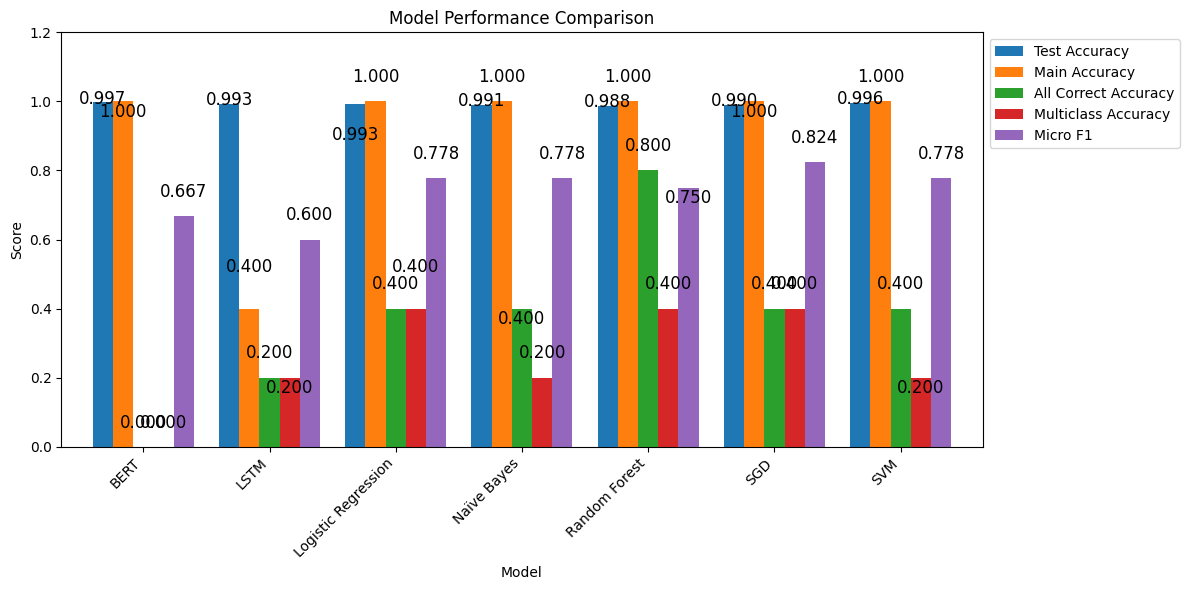

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Model": ["BERT", "LSTM", "Logistic Regression", "Naïve Bayes", "Random Forest", "SGD", "SVM"],
    "Test Accuracy": [0.997, 0.993, 0.993, 0.991, 0.988, 0.99, 0.996],
    "Main Accuracy": [1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0],
    "All Correct Accuracy": [0, 0.2, 0.4, 0.4, 0.8, 0.4, 0.4],
    "Multiclass Accuracy": [0.0, 0.2, 0.4, 0.2, 0.4, 0.4, 0.2],
    "Micro F1": [0.667, 0.6, 0.778, 0.778, 0.75, 0.824, 0.778]
}

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)

# Plot
ax = df.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add accuracy values above each bar with adjustments for Test Accuracy
for i, p in enumerate(ax.patches):
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2.
    y = height

    # Adjust y position for Test Accuracy annotations

    if i < len(df):  # Only apply to Test Accuracy bars
        y -= 0.03  # Lower the annotation (adjust value as needed)
    else:
        y += 0.03  # Raise the annotation (adjust value as needed)
    # all correct accuracy bar lower the annotation
    # Adjust for specific bars
    num_bars_per_model = len(df.columns)
    bar_index_in_group = i % num_bars_per_model
    if bar_index_in_group == 0:  # Test Accuracy
        pass  # No extra adjustment needed
    elif bar_index_in_group == 2:  # All Correct Accuracy
        y -= 0.10  # Lower significantly to avoid overlap
    elif bar_index_in_group == 3:  # Multiclass Accuracy
        if height < 0.5:  # Adjust if the bar is short
            y += 0.05       # Raise to ensure visibility


    # Annotate with adjusted position
    ax.annotate(f"{height:.3f}", (x, y),
                ha='center', va='center',
                xytext=(0, 10),  # Adjust vertical offset here
                textcoords='offset points',
                fontsize=12)
plt.tight_layout()
plt.show()


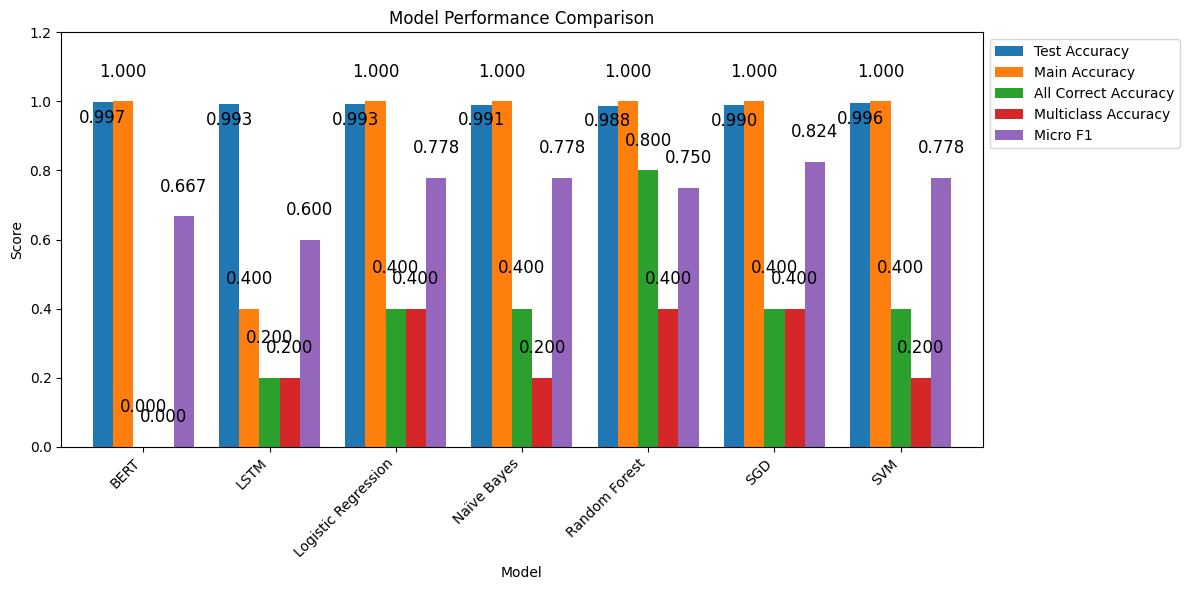

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Model": ["BERT", "LSTM", "Logistic Regression", "Naïve Bayes", "Random Forest", "SGD", "SVM"],
    "Test Accuracy": [0.997, 0.993, 0.993, 0.991, 0.988, 0.99, 0.996],
    "Main Accuracy": [1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0],
    "All Correct Accuracy": [0, 0.2, 0.4, 0.4, 0.8, 0.4, 0.4],
    "Multiclass Accuracy": [0.0, 0.2, 0.4, 0.2, 0.4, 0.4, 0.2],
    "Micro F1": [0.667, 0.6, 0.778, 0.778, 0.75, 0.824, 0.778]
}

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)

# Plot
ax = df.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

num_models = len(df)  # Number of models (7)
num_metrics = len(df.columns)  # Number of metrics (5)

# Add annotations
for i, p in enumerate(ax.patches):
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    metric_index = i // num_models  # Determine which metric group the bar belongs to
    model_index = i % num_models   # Determine which model in the metric group

    # Adjust position based on metric
    if metric_index == 0:  # Test Accuracy: place inside at the top
        va = 'top'
        y_pos = height - 0.02
        offset = 0 # Points downward
        color = 'black'  # Assumes dark bar color; adjust if needed
    else:  # Other metrics: place above the bar
        va = 'bottom'
        y_pos = height + 0.02
        offset = 10  # Points upward
        color = 'black'

    # Special case for All Correct Accuracy (metric_index 2) with low values
    if metric_index == 2 and height < 0.5:
        y_pos = height + 0.05  # Raise further to prevent overlap
    # Special case for Multiclass Accuracy (metric_index 3)
    elif metric_index == 3:
        y_pos = height + 0.02  # Ensure it's above the bar

    ax.annotate(f"{height:.3f}", (x, y_pos),
                ha='center', va=va,
                xytext=(0, offset),
                textcoords='offset points',
                fontsize=12,
                color=color)

plt.tight_layout()
plt.show()

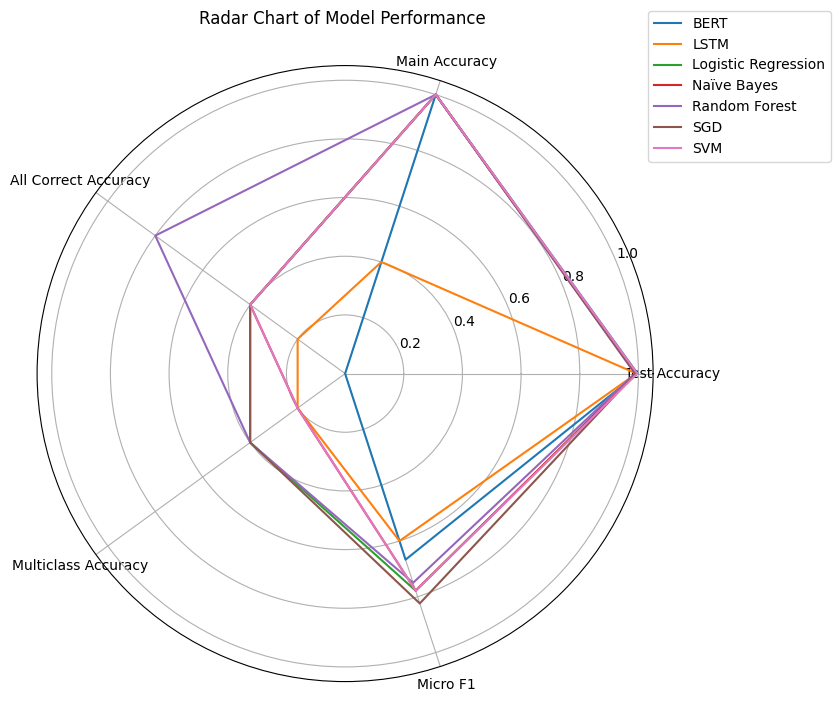

In [ ]:
import numpy as np

# Normalize data to 0-1 scale
# normalized_df = (df - df.min()) / (df.max() - df.min())

# Create radar chart
categories = list(df.columns)
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

for model in df.index:
    values = df.loc[model].tolist()
    values += values[:1]  # Close the radar chart
    ax.plot(angles + angles[:1], values, label=model)

ax.set_xticks(angles)
ax.set_xticklabels(categories)
plt.title("Radar Chart of Model Performance ",pad=30)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

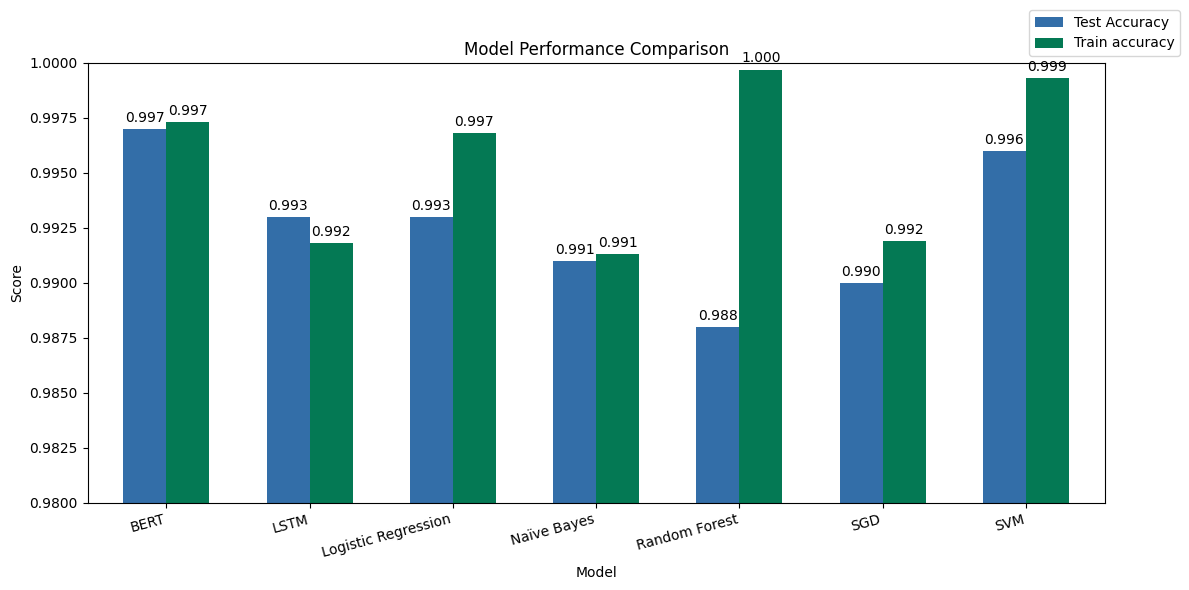

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Model": ["BERT", "LSTM", "Logistic Regression", "Naïve Bayes", "Random Forest", "SGD", "SVM"],
    "Test Accuracy": [0.997, 0.993, 0.993, 0.991, 0.988, 0.99, 0.996],
    "Train accuracy": [0.9973,0.9918,0.9968,0.9913,0.9997,0.9919,0.9993]
}

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)

# Plot with specified colors
ax = df.plot(kind="bar", figsize=(12, 6), width=0.6, color=['#336EA8', '#047954'])
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=15, ha='right')
plt.ylim(0.98, 1)
plt.legend(loc='lower center', bbox_to_anchor=(1, 1))

# Get the bar heights (values) directly from the DataFrame
bar_heights = df.values  # Or df[['Test Accuracy', 'Train accuracy']].values

# write each score above each bar
# Loop to add labels to each bar group
for i, bars in enumerate(ax.containers):
    ax.bar_label(bars, labels=[f'{x:.3f}' for x in bar_heights[:, i]],
                label_type='edge', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

Best Overall (Multi-Label): **Random Forest**

Best Single-Label: **BERT**

Most Balanced: **Logistic Regression/SVM**

Avoid: **LSTM** (underperforms in all metrics)

#pipeline

In [ ]:
!pip install contractions
# Download 'wordnet' dataset
!pip install textblob  # Install the textblob package

In [ ]:
import nltk # Import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  # Add this line to download the 'punkt_tab' resource
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import joblib
import tensorflow as tf
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification
import contractions
import nltk # Import nltk
from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer
from textblob import TextBlob # Import TextBlob

def clean_text_advanced(text):
    # Expand contractions
    text = contractions.fix(text)

    # Lowercase
    text = text.lower()

    # Remove digits and punctuation
    text = re.sub(r'\{\{.*?\}\}', '', text)

    text = text.split()
    text = ' '.join(text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

     # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    essential_words = {'not', 'no', 'cannot'}
    custom_stop_words = stop_words - essential_words
    tokens = [word for word in tokens if word not in custom_stop_words]


    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token,pos='v') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='v') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='a') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='r') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='s') for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos ='n') for token in tokens]

    # Join tokens back into a string
    cleaned_text = ' '.join(lemmatized_tokens)

    # Optional: Spell correction (can slow down processing)
    cleaned_text = str(TextBlob(cleaned_text).correct()) # Now TextBlob is defined

    # # Spell correction (optional - slow on large datasets)
    # text = str(TextBlob(text).correct())

    return cleaned_text


In [ ]:
# ========== IMPORTS & SETUP ========== #
import re
import string
import joblib
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import contractions
from textblob import TextBlob

# ========== COMPONENT LOADING ========== #
# Load preprocessing components
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/models4/tfidf_vectorizer.pkl")
label_encoder = joblib.load("/content/drive/MyDrive/models2/label_encoder.pkl")

# Load ML models
ml_models = {
    "Logistic Regression": joblib.load("/content/drive/MyDrive/models4/Logistic Regression.pkl"),
    "SVM": joblib.load("/content/drive/MyDrive/models4/SVM.pkl"),
    "SGD": joblib.load("/content/drive/MyDrive/models4/SGD.pkl"),
    "Random Forest": joblib.load("/content/drive/MyDrive/models2/Random Forest.pkl"),
    "Naïve Bayes": joblib.load("/content/drive/MyDrive/models4/Naïve Bayes.pkl")
}

# Load DL components
tokenizer_bert = BertTokenizer.from_pretrained("/content/drive/MyDrive/models2/bert_tokenizer_10")
bert_model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/models2/bert_model_10")
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/models55/lstm_model.h5")
with open("/content/drive/MyDrive/models55/tokenizer.pkl", "rb") as handle:
    lstm_tokenizer = pickle.load(handle)

lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/models55/lstm_model.h5")
max_length = 20  # Adjust based on your model's input size


# ========== TEXT PREPROCESSING ========== #
def clean_text_advanced(text):
    """Enhanced text cleaning pipeline"""
    # Contraction expansion
    text = contractions.fix(text)

    # Text normalization
    text = text.lower()
    text = re.sub(r'\{\{.*?\}\}', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    # Tokenization and stopword removal
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'cannot'}
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in tokens:
        for pos in [wordnet.VERB, wordnet.ADJ, wordnet.ADV, wordnet.NOUN]:
            lemmatized = lemmatizer.lemmatize(token, pos=pos)
            if lemmatized != token:
                break
        lemmatized_tokens.append(lemmatized)

    # Spell correction (optional)
    cleaned_text = ' '.join(lemmatized_tokens)
    return str(TextBlob(cleaned_text).correct())

# ========== PREDICTION ENGINE ========== #
def apply_dynamic_thresholding(probabilities):
    """Dynamic thresholding with label mapping"""
    categories = label_encoder.classes_
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probs = np.array(probabilities)[sorted_indices]
    sorted_cats = [categories[i] for i in sorted_indices]

    main_category = sorted_cats[0]
    additional = []
    high_conf_indices = [0]

    # Rule 1: High-confidence chain
    for i in range(1, len(sorted_probs)):
        if sorted_probs[i] >= 0.5 and (sorted_probs[i-1] - sorted_probs[i]) <= 0.2:
            high_conf_indices.append(i)
        else:
            break

    # Rule 2: Low-confidence clusters
    low_conf_probs = [(prob, idx) for idx, prob in enumerate(sorted_probs)
                     if (prob < 0.5 and prob > 0.1 and idx not in high_conf_indices)]

    # Cluster detection logic
    clusters = []
    current_cluster = []
    for prob, idx in low_conf_probs:
        if not current_cluster:
            current_cluster.append((prob, idx))
        else:
            if current_cluster[-1][0] - prob <= 0.1:
                current_cluster.append((prob, idx))
            else:
                clusters.append(current_cluster)
                current_cluster = [(prob, idx)]
    if current_cluster:
        clusters.append(current_cluster)

    # Cluster selection
    clusters.sort(key=lambda x: len(x), reverse=True)
    selected_low_conf = []
    for cluster in clusters:
        selected_low_conf.extend([idx for (prob, idx) in cluster])
        if len(selected_low_conf) >= 4 - len(high_conf_indices):
            break

    # Final selection
    all_selected = high_conf_indices + selected_low_conf[:4 - len(high_conf_indices)]
    additional = [(sorted_cats[idx], sorted_probs[idx]) for idx in all_selected if idx != 0]

    return main_category, additional

# ========== PREDICTION PIPELINES ========== #
def ml_pipeline(model, text):
    cleaned_text = clean_text_advanced(text)
    text_tfidf = tfidf_vectorizer.transform([cleaned_text])

    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(text_tfidf)[0]
    else:
        scores = model.decision_function(text_tfidf)[0]
        probs = 1 / (1 + np.exp(-scores))

    main, additional = apply_dynamic_thresholding(probs)
    return format_prediction(main, additional)

def lstm_pipeline(text):
    """End-to-end LSTM prediction pipeline"""
    cleaned_text = clean_text_advanced(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=20)
    probs = lstm_model.predict(padded, verbose=0)[0]
    main, additional = apply_dynamic_thresholding(probs)
    return format_prediction(main, additional)

def bert_pipeline(text):
    """End-to-end BERT prediction pipeline"""
    cleaned_text = clean_text_advanced(text)
    inputs = tokenizer_bert(cleaned_text,
                          return_tensors="tf",
                          padding=True,
                          truncation=True,
                          max_length=512)
    outputs = bert_model(**inputs)
    probs = tf.nn.softmax(outputs.logits, axis=-1).numpy()[0]
    main, additional = apply_dynamic_thresholding(probs)
    return format_prediction(main, additional)

# ========== RESULT FORMATTING ========== #
def format_prediction(main, additional):
    """Standardized prediction formatting"""
    additional_str = ", ".join([f"{label} ({prob:.2f})" for label, prob in additional[1:]])
    if additional_str:
        return f"Prediction: The main category of your ticket is under '{main}', and your ticket may also need to be considered in these other parts: {additional_str}."
    else:
        return f"Prediction: The main category of your ticket is under '{main}'."

# ========== EXECUTION ========== #
if __name__ == "__main__":
    # Suppress unnecessary warnings
    tf.get_logger().setLevel('ERROR')

    # Test text
    test_text = "I want to cancel my order and get a refund because I never received it."

    # Run all pipelines
    pipelines = {
        "Logistic Regression": lambda t: ml_pipeline(ml_models["Logistic Regression"], t),
        "SVM": lambda t: ml_pipeline(ml_models["SVM"], t),
        "SGD": lambda t: ml_pipeline(ml_models["SGD"], t),
        "Random Forest": lambda t: ml_pipeline(ml_models["Random Forest"], t),
        "Naïve Bayes": lambda t: ml_pipeline(ml_models["Naïve Bayes"], t),
        "LSTM": lstm_pipeline,
        "BERT": bert_pipeline
    }

    for model_name, pipeline in pipelines.items():
        try:
            print(f"\n=== {model_name} Prediction ===")
            print(pipeline(test_text))
        except Exception as e:
            print(f"Error in {model_name}: {str(e)}")


=== Logistic Regression Prediction ===
Prediction: The main category of your ticket is under 'get_refund'.

=== SVM Prediction ===
Prediction: The main category of your ticket is under 'cancel_order'.

=== SGD Prediction ===
Prediction: The main category of your ticket is under 'get_refund'.

=== Random Forest Prediction ===
Prediction: The main category of your ticket is under 'cancel_order'.

=== Naïve Bayes Prediction ===
Prediction: The main category of your ticket is under 'get_refund', and your ticket may also need to be considered in these other parts: delete_account (0.10).

=== LSTM Prediction ===
Prediction: The main category of your ticket is under 'get_invoice', and your ticket may also need to be considered in these other parts: cancel_order (0.12).

=== BERT Prediction ===
Prediction: The main category of your ticket is under 'get_refund'.


In [ ]:
import os
import re
import string
import joblib
import numpy as np
import tensorflow as tf
import contractions
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertForSequenceClassification



# Explicit function wrappers for ML pipelines (No lambdas)
def logistic_regression_pipeline(text):
    return ml_pipeline(ml_models["Logistic Regression"], text)

def svm_pipeline(text):
    return ml_pipeline(ml_models["SVM"], text)

def sgd_pipeline(text):
    return ml_pipeline(ml_models["SGD"], text)

def random_forest_pipeline(text):
    return ml_pipeline(ml_models["Random Forest"], text)

def naive_bayes_pipeline(text):
    return ml_pipeline(ml_models["Naïve Bayes"], text)

# Dictionary of Pipelines
full_pipeline = {
    "Logistic Regression Pipeline": logistic_regression_pipeline,
    "SVM Pipeline": svm_pipeline,
    "SGD Pipeline": sgd_pipeline,
    "Random Forest Pipeline": random_forest_pipeline,
    "Naïve Bayes Pipeline": naive_bayes_pipeline,
    "LSTM Pipeline": lstm_pipeline,
    "BERT Pipeline": bert_pipeline
}


# ✅ Save Each Pipeline Separately
os.makedirs("/content/drive/MyDrive/models5/", exist_ok=True)
joblib.dump(logistic_regression_pipeline, "/content/drive/MyDrive/models55/logistic_regression_pipeline.pkl")
joblib.dump(svm_pipeline, "/content/drive/MyDrive/models55/svm_pipeline.pkl")
joblib.dump(sgd_pipeline, "/content/drive/MyDrive/models55/sgd_pipeline.pkl")
joblib.dump(random_forest_pipeline, "/content/drive/MyDrive/models55/random_forest_pipeline.pkl")
joblib.dump(naive_bayes_pipeline, "/content/drive/MyDrive/models55/naive_bayes_pipeline.pkl")
joblib.dump(lstm_pipeline, "/content/drive/MyDrive/models55/lstm_pipeline.pkl")
joblib.dump(bert_pipeline, "/content/drive/MyDrive/models55/bert_pipeline.pkl")

print("✅ All pipelines saved separately!")

# ✅ Load Pipelines (To Verify)
loaded_logistic_regression_pipeline = joblib.load("/content/drive/MyDrive/models55/logistic_regression_pipeline.pkl")
loaded_svm_pipeline = joblib.load("/content/drive/MyDrive/models55/svm_pipeline.pkl")
loaded_sgd_pipeline = joblib.load("/content/drive/MyDrive/models55/sgd_pipeline.pkl")
loaded_random_forest_pipeline = joblib.load("/content/drive/MyDrive/models55/random_forest_pipeline.pkl")
loaded_naive_bayes_pipeline = joblib.load("/content/drive/MyDrive/models55/naive_bayes_pipeline.pkl")
loaded_lstm_pipeline = joblib.load("/content/drive/MyDrive/models55/lstm_pipeline.pkl")
loaded_bert_pipeline = joblib.load("/content/drive/MyDrive/models55/bert_pipeline.pkl")

# Test Pipelines
test_text = "I tried to contact support, but no human agent responded. My payment also failed!"

print("\nLogistic Regression:", loaded_logistic_regression_pipeline(test_text))
print("\nSVM:", loaded_svm_pipeline(test_text))
print("\nSGD:", loaded_sgd_pipeline(test_text))
print("\nRandom Forest:", loaded_random_forest_pipeline(test_text))
print("\nNaïve Bayes:", loaded_naive_bayes_pipeline(test_text))
print("\nLSTM Prediction:", loaded_lstm_pipeline(test_text))
print("\nBERT Prediction:", loaded_bert_pipeline(test_text))


✅ All pipelines saved separately!

Logistic Regression: Prediction: The main category of your ticket is under 'contact_human_agent'.

SVM: Prediction: The main category of your ticket is under 'contact_human_agent'.

SGD: Prediction: The main category of your ticket is under 'contact_human_agent'.

Random Forest: Prediction: The main category of your ticket is under 'contact_human_agent', and your ticket may also need to be considered in these other parts: check_payment_methods (0.11), payment_issue (0.32).

Naïve Bayes: Prediction: The main category of your ticket is under 'contact_human_agent'.

LSTM Prediction: Prediction: The main category of your ticket is under 'contact_human_agent'.

BERT Prediction: Prediction: The main category of your ticket is under 'payment_issue'.
